In [1]:
import pdb
import numpy as np
import policy_gradient_reinforce as policy_gradient
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
# Morvan's code is against TF 1.0
tf.disable_v2_behavior() 

# Each policy can only increase, decrease, or stay by a certain ACTION_DELTA.
NUM_ACTION = 3

# TODO: Tweak all the parameters below per optimization problem
ACTION_DELTA = 0.1
# How many timesteps to look back for state. Ke li 2017 used 25.
NUM_TIMESTEPS_FOR_STATE = 3
# The number of episodes / full game. Each episode starts from the initial state w0.
NUM_EPISODES = 10
# Number of steps per episode
EPISODE_LEN = 15
# Learning rate for policy gradient
LEARNING_RATE = 0.02
# If True, then print verbose learning information
IS_DEBUG = False

def optimize_with_rl(f, g, w0):
  """
  Params
    f - The objective function to be maximized. f(w) should return a scalar.
    w0 - Initial w.
  Returns
    w such that f(w) is maximized
  """
  w0 = np.copy(w0)
  tf.reset_default_graph()
  opt_param_dim = len(w0)

  # TODO: Use scipy to get x0. Right now everything is just set to w0, f(w0)
  f_w0 = f(w0)
  g_w0 = g(w0)
  
  # wt and f_histories are not explicitly encoded as states, but are necessary to be updated
  # because they are used for next state calculations.
  wt = w0
  
  # Store histories of w, f(w(t)) and g(w(t)). First element is the most recent.
  w_histories = [w0] * NUM_TIMESTEPS_FOR_STATE
  f_histories = [f_w0] * NUM_TIMESTEPS_FOR_STATE
  g_histories = [g_w0] * NUM_TIMESTEPS_FOR_STATE
  # Initially, we don't have any changes in obj functions
  x0 = state_creator_fw_and_gradient(w_histories, f_histories, g_histories, f_w0)
  xt = x0
  
  state_dim = len(x0)
  # Each policies[i] is an RL model for tweaking the 1 parameter dimension w[i]
  policies = []
  for i in range(opt_param_dim):
    RL = policy_gradient.PolicyGradient(
      name_suffix=str(i),
      n_actions=NUM_ACTION,
      n_features=state_dim,
      learning_rate=LEARNING_RATE,
      reward_decay=1.0
    )
    policies.append(RL)
  
  # Total reward from start to finish of each episode
  ep_rewards = []
  ep_fws = []
  for ep in range(NUM_EPISODES):
    for t in range(EPISODE_LEN):
      # Every policy will have its own reward.
      rs = np.zeros(opt_param_dim)
      last_f_wt = 0
      for i in range(opt_param_dim):
        # The actions are numbers from 0 to NUM_ACTION - 1
        action = policies[i].choose_action(xt)
        if IS_DEBUG:
          print("t=%d i=%d action=%s" % (t, i, action))
          print("wt_prev=%s" % (wt))
        # TODO: Bounding?
        wt[i] += convert_action_to_dw(action)
        last_f_wt = f(wt)
        last_g_wt = g(wt)
        # TODO: Does the code work well with negative reward?
        rs[i] = last_f_wt
        if IS_DEBUG:
          print("wt_next=%s" % (wt))
          print("f(wt)=%s" % last_f_wt)
          print("rs=%s" % (rs))
        # TODO: Should we make the state observed by each policy change?
        # Right now this means that every time an agent acts,
        # the other agents are part of the stochastic environment,
        # And yet my reward is only computed off my immediate action.
        # Ez change: Just do the xt updates here.
        policies[i].store_transition(xt, action, rs[i])
        #print("t=%d i=%d a=%d wt=%s rs = %s xt=%s" %
        #      (t, i, action, wt, rs, xt))
      
      if IS_DEBUG:
        print("xt_prev=%s" % (xt))
      xt = state_creator_fw_and_gradient(w_histories, f_histories, g_histories, last_f_wt)
      
      # Rotate histories w/ the most recent f_wt entry
      # Rotate f_histories w/ the most recent f_wt entry
      f_histories = [last_f_wt] + f_histories[:-1]
      g_histories = [last_g_wt] + g_histories[:-1]
      w_histories = [np.copy(wt)] + w_histories[:-1]
      if IS_DEBUG:
        print("xt_next=%s" % (xt))
        print("f_hist=%s" % (f_histories))
        print("g_hist=%s" % (g_histories))
        print("w_hist=%s" % (w_histories))
    # The end of 1 episode  
    for policy in policies:
      ep_rewards.append(sum(policy.ep_rs))
      if IS_DEBUG:
        print("Sum rl.ep_rs = %.2f" % ep_rewards[-1])
      vt = policy.learn()
      if IS_DEBUG:
        print("rl.learn.vt = %s" % vt)
        plt.plot(vt)    # plot the episode vt
        plt.xlabel('episode steps')
        plt.ylabel('normalized state-action value')
        plt.show()
    ep_fws.append(last_f_wt)
    if IS_DEBUG:
      print("Episode %d, f(w) = %.2f, w = %s" % (ep+1, last_f_wt, wt))
  plt.plot(ep_rewards)
  plt.xlabel('episode')
  plt.ylabel('total reward')
  plt.show()
          
  plt.plot(ep_fws)
  plt.xlabel('episode')
  plt.ylabel('last f(w)')
  plt.show()
  return last_f_wt

def state_creator_fw_and_gradient(w_histories, f_histories, g_histories, last_f_wt):
  """
  # State space is as described by Ke li 2017:
  # - Changes in the objective value at the current location relative to the objective value
  #    at the ith most recent location for all i
  # - Gradient of the objective function evaluated at the ith most recent location for all i 
  # We do NOT include the current weights as state like Ke li 2017:
  # "The current location is only used to compute the cost; because the policy
  # "should not depend on the absolute coordinates of the current location,
  # "we exclude it from the input that is fed into the neural net"
  # The format is: delta_f * NUM_TIMESTEPS_FOR_STATE, then grad_f * NUM_TIMESTEPS_FOR_STATE
  #   Most recent chunk is at the front of the array
  """ 
  xt_fs = last_f_wt - np.array(f_histories)
  xt_gs = np.array(g_histories).flatten()
  return np.append(xt_fs, xt_gs)
  
def convert_action_to_dw(action):
  if action == 0:
    return 0
  elif action == 1:
    return -ACTION_DELTA
  else:
    return ACTION_DELTA

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
t=0 i=0 action=1
wt_prev=[2.]
wt_next=[1.9]
f(wt)=4.19
rs=[4.19]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[ 0.19  0.19  0.19 -2.   -2.   -2.  ]
f_hist=[4.19, 4.0, 4.0]
g_hist=[array([-1.8]), array([-2.]), array([-2.])]
w_hist=[array([1.9]), array([1.9]), array([1.9])]
t=1 i=0 action=2
wt_prev=[1.9]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.19  0.19  0.19 -2.   -2.   -2.  ]
xt_next=[-0.19  0.    0.   -1.8  -2.   -2.  ]
f_hist=[4.0, 4.19, 4.0]
g_hist=[array([-2.]), array([-1.8]), array([-2.])]
w_hist=[array([2.]), array([1.9]), array([2.])]
t=2 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[-0.19  0.    0.   -1.8  -2.   -2.  ]
xt_next=[ 0.   -0.19  0.   -2.   -1.8  -2.  ]
f_hist=[4.0, 4.0, 4.19]
g_hist=[array([-2.]), array([-2.]), array([-1.8])]
w_hist=[array([2.]), array([2.]), array([1.9])]
t=3 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt

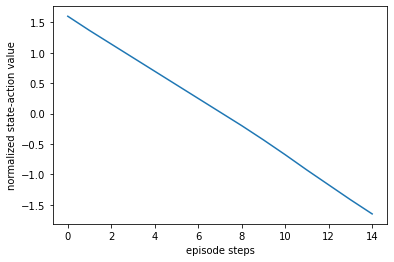

Episode 1, f(w) = 4.19, w = [1.9]
t=0 i=0 action=1
wt_prev=[1.9]
wt_next=[1.8]
f(wt)=4.36
rs=[4.36]
xt_prev=[ 0.   -0.17 -0.17 -1.8  -1.6  -1.6 ]
xt_next=[ 0.17  0.17  0.   -1.8  -1.8  -1.6 ]
f_hist=[4.36, 4.19, 4.19]
g_hist=[array([-1.6]), array([-1.8]), array([-1.8])]
w_hist=[array([1.8]), array([1.9]), array([1.9])]
t=1 i=0 action=1
wt_prev=[1.8]
wt_next=[1.7]
f(wt)=4.510000000000001
rs=[4.51]
xt_prev=[ 0.17  0.17  0.   -1.8  -1.8  -1.6 ]
xt_next=[ 0.15  0.32  0.32 -1.6  -1.8  -1.8 ]
f_hist=[4.510000000000001, 4.36, 4.19]
g_hist=[array([-1.4]), array([-1.6]), array([-1.8])]
w_hist=[array([1.7]), array([1.8]), array([1.9])]
t=2 i=0 action=1
wt_prev=[1.7]
wt_next=[1.6]
f(wt)=4.640000000000001
rs=[4.64]
xt_prev=[ 0.15  0.32  0.32 -1.6  -1.8  -1.8 ]
xt_next=[ 0.13  0.28  0.45 -1.4  -1.6  -1.8 ]
f_hist=[4.640000000000001, 4.510000000000001, 4.36]
g_hist=[array([-1.2]), array([-1.4]), array([-1.6])]
w_hist=[array([1.6]), array([1.7]), array([1.8])]
t=3 i=0 action=0
wt_prev=[1.6]
wt_next=[

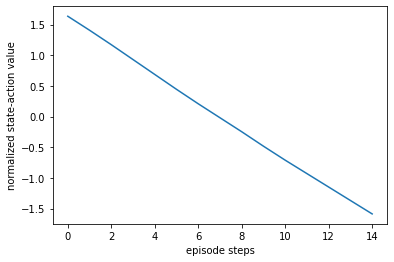

Episode 2, f(w) = 4.00, w = [2.]
t=0 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[-0.19 -0.19 -0.19 -1.8  -1.8  -1.8 ]
xt_next=[ 0.   -0.19 -0.19 -2.   -1.8  -1.8 ]
f_hist=[4.0, 4.0, 4.19]
g_hist=[array([-2.]), array([-2.]), array([-1.8])]
w_hist=[array([2.]), array([2.]), array([1.9])]
t=1 i=0 action=1
wt_prev=[2.]
wt_next=[1.9]
f(wt)=4.19
rs=[4.19]
xt_prev=[ 0.   -0.19 -0.19 -2.   -1.8  -1.8 ]
xt_next=[ 0.19  0.19  0.   -2.   -2.   -1.8 ]
f_hist=[4.19, 4.0, 4.0]
g_hist=[array([-1.8]), array([-2.]), array([-2.])]
w_hist=[array([1.9]), array([2.]), array([2.])]
t=2 i=0 action=2
wt_prev=[1.9]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.19  0.19  0.   -2.   -2.   -1.8 ]
xt_next=[-0.19  0.    0.   -1.8  -2.   -2.  ]
f_hist=[4.0, 4.19, 4.0]
g_hist=[array([-2.]), array([-1.8]), array([-2.])]
w_hist=[array([2.]), array([1.9]), array([2.])]
t=3 i=0 action=1
wt_prev=[2.]
wt_next=[1.9]
f(wt)=4.19
rs=[4.19]
xt_prev=[-0.19  0.    0.   -1.8  -2.   -2.  ]
xt_next=[ 0.19  0.    0

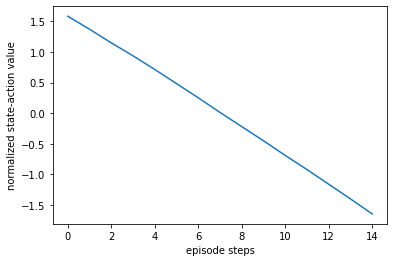

Episode 3, f(w) = 4.64, w = [1.6]
t=0 i=0 action=1
wt_prev=[1.6]
wt_next=[1.5]
f(wt)=4.75
rs=[4.75]
xt_prev=[ 0.    0.13  0.13 -1.2  -1.4  -1.4 ]
xt_next=[ 0.11  0.11  0.24 -1.2  -1.2  -1.4 ]
f_hist=[4.75, 4.640000000000001, 4.640000000000001]
g_hist=[array([-1.]), array([-1.2]), array([-1.2])]
w_hist=[array([1.5]), array([1.6]), array([1.6])]
t=1 i=0 action=2
wt_prev=[1.5]
wt_next=[1.6]
f(wt)=4.640000000000001
rs=[4.64]
xt_prev=[ 0.11  0.11  0.24 -1.2  -1.2  -1.4 ]
xt_next=[-0.11  0.    0.   -1.   -1.2  -1.2 ]
f_hist=[4.640000000000001, 4.75, 4.640000000000001]
g_hist=[array([-1.2]), array([-1.]), array([-1.2])]
w_hist=[array([1.6]), array([1.5]), array([1.6])]
t=2 i=0 action=0
wt_prev=[1.6]
wt_next=[1.6]
f(wt)=4.640000000000001
rs=[4.64]
xt_prev=[-0.11  0.    0.   -1.   -1.2  -1.2 ]
xt_next=[ 0.   -0.11  0.   -1.2  -1.   -1.2 ]
f_hist=[4.640000000000001, 4.640000000000001, 4.75]
g_hist=[array([-1.2]), array([-1.2]), array([-1.])]
w_hist=[array([1.6]), array([1.6]), array([1.5])]
t=3 

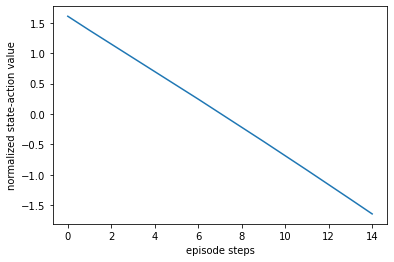

Episode 4, f(w) = 4.99, w = [1.1]
t=0 i=0 action=0
wt_prev=[1.1]
wt_next=[1.1]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.03  0.08  0.08 -0.4  -0.6  -0.6 ]
xt_next=[ 0.    0.03  0.08 -0.2  -0.4  -0.6 ]
f_hist=[4.99, 4.99, 4.96]
g_hist=[array([-0.2]), array([-0.2]), array([-0.4])]
w_hist=[array([1.1]), array([1.1]), array([1.2])]
t=1 i=0 action=1
wt_prev=[1.1]
wt_next=[1.]
f(wt)=5.0
rs=[5.]
xt_prev=[ 0.    0.03  0.08 -0.2  -0.4  -0.6 ]
xt_next=[ 0.01  0.01  0.04 -0.2  -0.2  -0.4 ]
f_hist=[5.0, 4.99, 4.99]
g_hist=[array([1.55431223e-15]), array([-0.2]), array([-0.2])]
w_hist=[array([1.]), array([1.1]), array([1.1])]
t=2 i=0 action=1
wt_prev=[1.]
wt_next=[0.9]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.01  0.01  0.04 -0.2  -0.2  -0.4 ]
xt_next=[-1.00000000e-02  0.00000000e+00  0.00000000e+00  1.55431223e-15
 -2.00000000e-01 -2.00000000e-01]
f_hist=[4.99, 5.0, 4.99]
g_hist=[array([0.2]), array([1.55431223e-15]), array([-0.2])]
w_hist=[array([0.9]), array([1.]), array([1.1])]
t=3 i=0 action=1
wt_prev=[0.9]
wt_

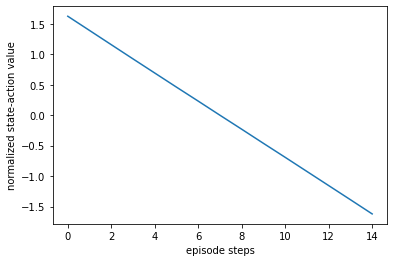

Episode 5, f(w) = 4.96, w = [0.8]
t=0 i=0 action=0
wt_prev=[0.8]
wt_next=[0.8]
f(wt)=4.96
rs=[4.96]
xt_prev=[-0.03  0.    0.    0.2   0.4   0.4 ]
xt_next=[ 0.   -0.03  0.    0.4   0.2   0.4 ]
f_hist=[4.96, 4.96, 4.99]
g_hist=[array([0.4]), array([0.4]), array([0.2])]
w_hist=[array([0.8]), array([0.8]), array([0.9])]
t=1 i=0 action=2
wt_prev=[0.8]
wt_next=[0.9]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.   -0.03  0.    0.4   0.2   0.4 ]
xt_next=[0.03 0.03 0.   0.4  0.4  0.2 ]
f_hist=[4.99, 4.96, 4.96]
g_hist=[array([0.2]), array([0.4]), array([0.4])]
w_hist=[array([0.9]), array([0.8]), array([0.8])]
t=2 i=0 action=0
wt_prev=[0.9]
wt_next=[0.9]
f(wt)=4.99
rs=[4.99]
xt_prev=[0.03 0.03 0.   0.4  0.4  0.2 ]
xt_next=[0.   0.03 0.03 0.2  0.4  0.4 ]
f_hist=[4.99, 4.99, 4.96]
g_hist=[array([0.2]), array([0.2]), array([0.4])]
w_hist=[array([0.9]), array([0.9]), array([0.8])]
t=3 i=0 action=2
wt_prev=[0.9]
wt_next=[1.]
f(wt)=5.0
rs=[5.]
xt_prev=[0.   0.03 0.03 0.2  0.4  0.4 ]
xt_next=[0.01 0.01 0.04 0.2  0

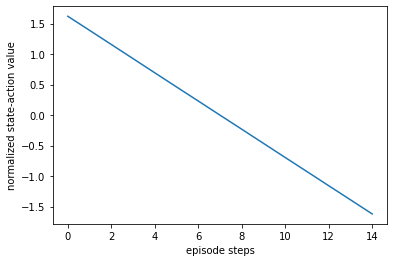

Episode 6, f(w) = 5.00, w = [1.]
t=0 i=0 action=0
wt_prev=[1.]
wt_next=[1.]
f(wt)=5.0
rs=[5.]
xt_prev=[ 0.01  0.04  0.01 -0.2  -0.4  -0.2 ]
xt_next=[ 0.00000000e+00  1.00000000e-02  4.00000000e-02  1.55431223e-15
 -2.00000000e-01 -4.00000000e-01]
f_hist=[5.0, 5.0, 4.99]
g_hist=[array([1.55431223e-15]), array([1.55431223e-15]), array([-0.2])]
w_hist=[array([1.]), array([1.]), array([1.1])]
t=1 i=0 action=2
wt_prev=[1.]
wt_next=[1.1]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.00000000e+00  1.00000000e-02  4.00000000e-02  1.55431223e-15
 -2.00000000e-01 -4.00000000e-01]
xt_next=[-1.00000000e-02 -1.00000000e-02  0.00000000e+00  1.55431223e-15
  1.55431223e-15 -2.00000000e-01]
f_hist=[4.99, 5.0, 5.0]
g_hist=[array([-0.2]), array([1.55431223e-15]), array([1.55431223e-15])]
w_hist=[array([1.1]), array([1.]), array([1.])]
t=2 i=0 action=1
wt_prev=[1.1]
wt_next=[1.]
f(wt)=5.0
rs=[5.]
xt_prev=[-1.00000000e-02 -1.00000000e-02  0.00000000e+00  1.55431223e-15
  1.55431223e-15 -2.00000000e-01]
xt_next=[ 1.000

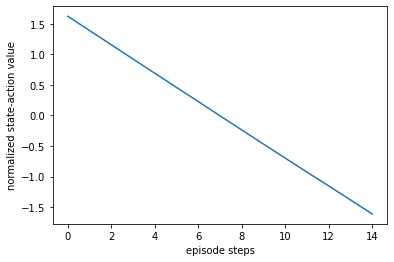

Episode 7, f(w) = 4.96, w = [0.8]
t=0 i=0 action=2
wt_prev=[0.8]
wt_next=[0.9]
f(wt)=4.99
rs=[4.99]
xt_prev=[0.05 0.05 0.12 0.6  0.6  0.8 ]
xt_next=[0.03 0.08 0.08 0.4  0.6  0.6 ]
f_hist=[4.99, 4.96, 4.909999999999999]
g_hist=[array([0.2]), array([0.4]), array([0.6])]
w_hist=[array([0.9]), array([0.8]), array([0.7])]
t=1 i=0 action=0
wt_prev=[0.9]
wt_next=[0.9]
f(wt)=4.99
rs=[4.99]
xt_prev=[0.03 0.08 0.08 0.4  0.6  0.6 ]
xt_next=[0.   0.03 0.08 0.2  0.4  0.6 ]
f_hist=[4.99, 4.99, 4.96]
g_hist=[array([0.2]), array([0.2]), array([0.4])]
w_hist=[array([0.9]), array([0.9]), array([0.8])]
t=2 i=0 action=2
wt_prev=[0.9]
wt_next=[1.]
f(wt)=5.0
rs=[5.]
xt_prev=[0.   0.03 0.08 0.2  0.4  0.6 ]
xt_next=[0.01 0.01 0.04 0.2  0.2  0.4 ]
f_hist=[5.0, 4.99, 4.99]
g_hist=[array([1.55431223e-15]), array([0.2]), array([0.2])]
w_hist=[array([1.]), array([0.9]), array([0.9])]
t=3 i=0 action=2
wt_prev=[1.]
wt_next=[1.1]
f(wt)=4.99
rs=[4.99]
xt_prev=[0.01 0.01 0.04 0.2  0.2  0.4 ]
xt_next=[-1.00000000e-02  0

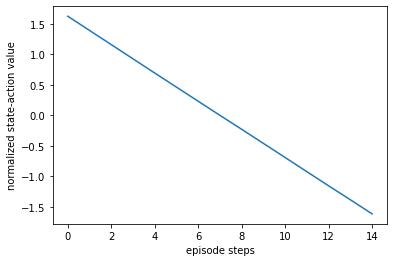

Episode 8, f(w) = 4.96, w = [1.2]
t=0 i=0 action=0
wt_prev=[1.2]
wt_next=[1.2]
f(wt)=4.96
rs=[4.96]
xt_prev=[ 0.    0.05  0.   -0.4  -0.6  -0.4 ]
xt_next=[ 0.    0.    0.05 -0.4  -0.4  -0.6 ]
f_hist=[4.96, 4.96, 4.96]
g_hist=[array([-0.4]), array([-0.4]), array([-0.4])]
w_hist=[array([1.2]), array([1.2]), array([1.2])]
t=1 i=0 action=0
wt_prev=[1.2]
wt_next=[1.2]
f(wt)=4.96
rs=[4.96]
xt_prev=[ 0.    0.    0.05 -0.4  -0.4  -0.6 ]
xt_next=[ 0.   0.   0.  -0.4 -0.4 -0.4]
f_hist=[4.96, 4.96, 4.96]
g_hist=[array([-0.4]), array([-0.4]), array([-0.4])]
w_hist=[array([1.2]), array([1.2]), array([1.2])]
t=2 i=0 action=0
wt_prev=[1.2]
wt_next=[1.2]
f(wt)=4.96
rs=[4.96]
xt_prev=[ 0.   0.   0.  -0.4 -0.4 -0.4]
xt_next=[ 0.   0.   0.  -0.4 -0.4 -0.4]
f_hist=[4.96, 4.96, 4.96]
g_hist=[array([-0.4]), array([-0.4]), array([-0.4])]
w_hist=[array([1.2]), array([1.2]), array([1.2])]
t=3 i=0 action=0
wt_prev=[1.2]
wt_next=[1.2]
f(wt)=4.96
rs=[4.96]
xt_prev=[ 0.   0.   0.  -0.4 -0.4 -0.4]
xt_next=[ 0.   0.

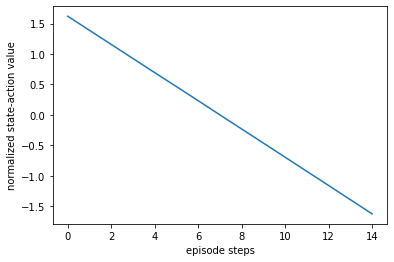

Episode 9, f(w) = 4.96, w = [1.2]
t=0 i=0 action=0
wt_prev=[1.2]
wt_next=[1.2]
f(wt)=4.96
rs=[4.96]
xt_prev=[-0.03 -0.03  0.   -0.2  -0.2  -0.4 ]
xt_next=[ 0.   -0.03 -0.03 -0.4  -0.2  -0.2 ]
f_hist=[4.96, 4.96, 4.99]
g_hist=[array([-0.4]), array([-0.4]), array([-0.2])]
w_hist=[array([1.2]), array([1.2]), array([1.1])]
t=1 i=0 action=2
wt_prev=[1.2]
wt_next=[1.3]
f(wt)=4.91
rs=[4.91]
xt_prev=[ 0.   -0.03 -0.03 -0.4  -0.2  -0.2 ]
xt_next=[-0.05 -0.05 -0.08 -0.4  -0.4  -0.2 ]
f_hist=[4.91, 4.96, 4.96]
g_hist=[array([-0.6]), array([-0.4]), array([-0.4])]
w_hist=[array([1.3]), array([1.2]), array([1.2])]
t=2 i=0 action=1
wt_prev=[1.3]
wt_next=[1.2]
f(wt)=4.96
rs=[4.96]
xt_prev=[-0.05 -0.05 -0.08 -0.4  -0.4  -0.2 ]
xt_next=[ 0.05  0.    0.   -0.6  -0.4  -0.4 ]
f_hist=[4.96, 4.91, 4.96]
g_hist=[array([-0.4]), array([-0.6]), array([-0.4])]
w_hist=[array([1.2]), array([1.3]), array([1.2])]
t=3 i=0 action=2
wt_prev=[1.2]
wt_next=[1.3]
f(wt)=4.91
rs=[4.91]
xt_prev=[ 0.05  0.    0.   -0.6  -0.4  

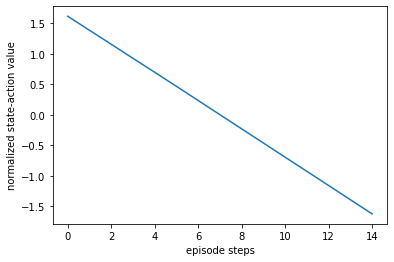

Episode 10, f(w) = 4.99, w = [0.9]


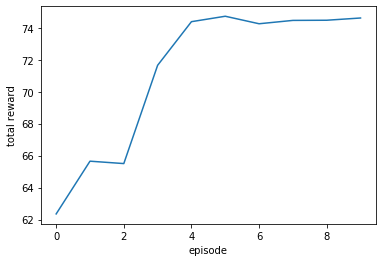

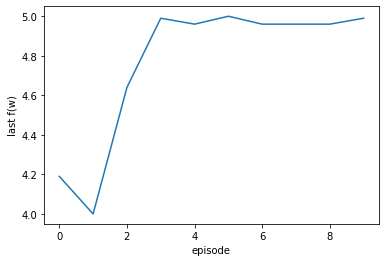

t=0 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[ 0.  0.  0. -2. -2. -2.]
f_hist=[4.0, 4.0, 4.0]
g_hist=[array([-2.]), array([-2.]), array([-2.])]
w_hist=[array([2.]), array([2.]), array([2.])]
t=1 i=0 action=2
wt_prev=[2.]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
f_hist=[3.79, 4.0, 4.0]
g_hist=[array([-2.2]), array([-2.]), array([-2.])]
w_hist=[array([2.1]), array([2.]), array([2.1])]
t=2 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
xt_next=[ 0.   -0.21 -0.21 -2.2  -2.   -2.  ]
f_hist=[3.79, 3.79, 4.0]
g_hist=[array([-2.2]), array([-2.2]), array([-2.])]
w_hist=[array([2.1]), array([2.1]), array([2.])]
t=3 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.   -0.21 -0.21 -2.2  -2.   -2.  ]
xt_next=[ 0.    0.   -0.21 -2.2  -2.2  -2.  ]
f_hist=[3.79, 3.79, 3.79]
g_hist=[array(

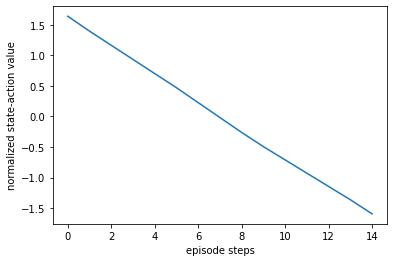

Episode 1, f(w) = 3.79, w = [2.1]
t=0 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.    0.23  0.23 -2.2  -2.4  -2.4 ]
xt_next=[ 0.    0.    0.23 -2.2  -2.2  -2.4 ]
f_hist=[3.79, 3.79, 3.79]
g_hist=[array([-2.2]), array([-2.2]), array([-2.2])]
w_hist=[array([2.1]), array([2.1]), array([2.1])]
t=1 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.    0.    0.23 -2.2  -2.2  -2.4 ]
xt_next=[ 0.   0.   0.  -2.2 -2.2 -2.2]
f_hist=[3.79, 3.79, 3.79]
g_hist=[array([-2.2]), array([-2.2]), array([-2.2])]
w_hist=[array([2.1]), array([2.1]), array([2.1])]
t=2 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.   0.   0.  -2.2 -2.2 -2.2]
xt_next=[ 0.   0.   0.  -2.2 -2.2 -2.2]
f_hist=[3.79, 3.79, 3.79]
g_hist=[array([-2.2]), array([-2.2]), array([-2.2])]
w_hist=[array([2.1]), array([2.1]), array([2.1])]
t=3 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.   0.   0.  -2.2 -2.2 -2.2]
xt_next=[ 0.   0.

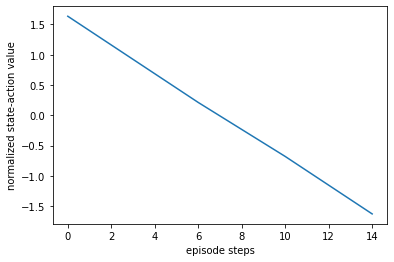

Episode 2, f(w) = 3.79, w = [2.1]
t=0 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.   0.   0.  -2.2 -2.2 -2.2]
xt_next=[ 0.   0.   0.  -2.2 -2.2 -2.2]
f_hist=[3.79, 3.79, 3.79]
g_hist=[array([-2.2]), array([-2.2]), array([-2.2])]
w_hist=[array([2.1]), array([2.1]), array([2.1])]
t=1 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.   0.   0.  -2.2 -2.2 -2.2]
xt_next=[ 0.   0.   0.  -2.2 -2.2 -2.2]
f_hist=[3.79, 3.79, 3.79]
g_hist=[array([-2.2]), array([-2.2]), array([-2.2])]
w_hist=[array([2.1]), array([2.1]), array([2.1])]
t=2 i=0 action=1
wt_prev=[2.1]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.   0.   0.  -2.2 -2.2 -2.2]
xt_next=[ 0.21  0.21  0.21 -2.2  -2.2  -2.2 ]
f_hist=[4.0, 3.79, 3.79]
g_hist=[array([-2.]), array([-2.2]), array([-2.2])]
w_hist=[array([2.]), array([2.1]), array([2.1])]
t=3 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.21  0.21  0.21 -2.2  -2.2  -2.2 ]
xt_next=[ 0.    0.21  0.21 -2.   -2

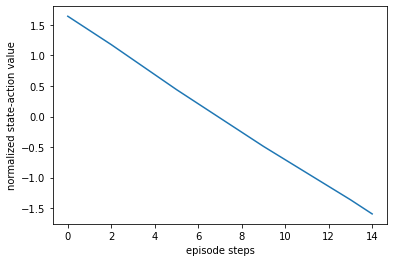

Episode 3, f(w) = 3.56, w = [2.2]
t=0 i=0 action=2
wt_prev=[2.2]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[-0.23  0.    0.   -2.2  -2.4  -2.4 ]
xt_next=[-0.25 -0.48 -0.25 -2.4  -2.2  -2.4 ]
f_hist=[3.3099999999999996, 3.5599999999999996, 3.79]
g_hist=[array([-2.6]), array([-2.4]), array([-2.2])]
w_hist=[array([2.3]), array([2.2]), array([2.1])]
t=1 i=0 action=0
wt_prev=[2.3]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[-0.25 -0.48 -0.25 -2.4  -2.2  -2.4 ]
xt_next=[ 0.   -0.25 -0.48 -2.6  -2.4  -2.2 ]
f_hist=[3.3099999999999996, 3.3099999999999996, 3.5599999999999996]
g_hist=[array([-2.6]), array([-2.6]), array([-2.4])]
w_hist=[array([2.3]), array([2.3]), array([2.2])]
t=2 i=0 action=0
wt_prev=[2.3]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[ 0.   -0.25 -0.48 -2.6  -2.4  -2.2 ]
xt_next=[ 0.    0.   -0.25 -2.6  -2.6  -2.4 ]
f_hist=[3.3099999999999996, 3.3099999999999996, 3.3099999999999996]
g_hist=[array([-2.6]), array([-2.6]), array([-2.6])]
w

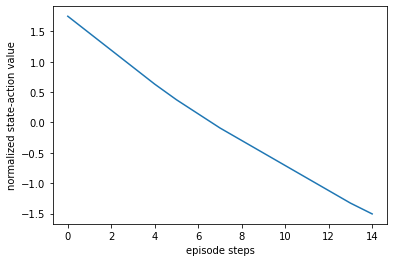

Episode 4, f(w) = 1.76, w = [2.8]
t=0 i=0 action=0
wt_prev=[2.8]
wt_next=[2.8]
f(wt)=1.7599999999999976
rs=[1.76]
xt_prev=[-0.35 -0.68 -0.68 -3.4  -3.2  -3.2 ]
xt_next=[ 0.   -0.35 -0.68 -3.6  -3.4  -3.2 ]
f_hist=[1.7599999999999976, 1.7599999999999976, 2.109999999999998]
g_hist=[array([-3.6]), array([-3.6]), array([-3.4])]
w_hist=[array([2.8]), array([2.8]), array([2.7])]
t=1 i=0 action=2
wt_prev=[2.8]
wt_next=[2.9]
f(wt)=1.389999999999997
rs=[1.39]
xt_prev=[ 0.   -0.35 -0.68 -3.6  -3.4  -3.2 ]
xt_next=[-0.37 -0.37 -0.72 -3.6  -3.6  -3.4 ]
f_hist=[1.389999999999997, 1.7599999999999976, 1.7599999999999976]
g_hist=[array([-3.8]), array([-3.6]), array([-3.6])]
w_hist=[array([2.9]), array([2.8]), array([2.8])]
t=2 i=0 action=0
wt_prev=[2.9]
wt_next=[2.9]
f(wt)=1.389999999999997
rs=[1.39]
xt_prev=[-0.37 -0.37 -0.72 -3.6  -3.6  -3.4 ]
xt_next=[ 0.   -0.37 -0.37 -3.8  -3.6  -3.6 ]
f_hist=[1.389999999999997, 1.389999999999997, 1.7599999999999976]
g_hist=[array([-3.8]), array([-3.8]), array([-

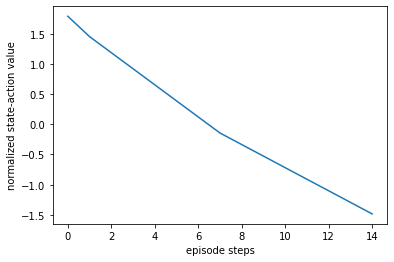

Episode 5, f(w) = 1.00, w = [3.]
t=0 i=0 action=2
wt_prev=[3.]
wt_next=[3.1]
f(wt)=0.5899999999999963
rs=[0.59]
xt_prev=[ 0.  0.  0. -4. -4. -4.]
xt_next=[-0.41 -0.41 -0.41 -4.   -4.   -4.  ]
f_hist=[0.5899999999999963, 0.9999999999999964, 0.9999999999999964]
g_hist=[array([-4.2]), array([-4.]), array([-4.])]
w_hist=[array([3.1]), array([3.]), array([3.])]
t=1 i=0 action=0
wt_prev=[3.1]
wt_next=[3.1]
f(wt)=0.5899999999999963
rs=[0.59]
xt_prev=[-0.41 -0.41 -0.41 -4.   -4.   -4.  ]
xt_next=[ 0.   -0.41 -0.41 -4.2  -4.   -4.  ]
f_hist=[0.5899999999999963, 0.5899999999999963, 0.9999999999999964]
g_hist=[array([-4.2]), array([-4.2]), array([-4.])]
w_hist=[array([3.1]), array([3.1]), array([3.])]
t=2 i=0 action=0
wt_prev=[3.1]
wt_next=[3.1]
f(wt)=0.5899999999999963
rs=[0.59]
xt_prev=[ 0.   -0.41 -0.41 -4.2  -4.   -4.  ]
xt_next=[ 0.    0.   -0.41 -4.2  -4.2  -4.  ]
f_hist=[0.5899999999999963, 0.5899999999999963, 0.5899999999999963]
g_hist=[array([-4.2]), array([-4.2]), array([-4.2])]
w_hist=

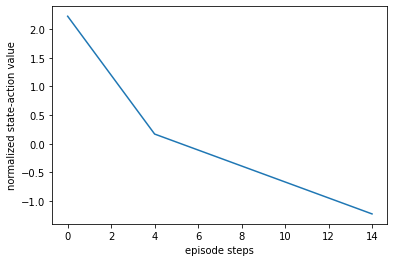

Episode 6, f(w) = 0.16, w = [3.2]
t=0 i=0 action=0
wt_prev=[3.2]
wt_next=[3.2]
f(wt)=0.1599999999999957
rs=[0.16]
xt_prev=[ 0.   0.   0.  -4.4 -4.4 -4.4]
xt_next=[ 0.   0.   0.  -4.4 -4.4 -4.4]
f_hist=[0.1599999999999957, 0.1599999999999957, 0.1599999999999957]
g_hist=[array([-4.4]), array([-4.4]), array([-4.4])]
w_hist=[array([3.2]), array([3.2]), array([3.2])]
t=1 i=0 action=2
wt_prev=[3.2]
wt_next=[3.3]
f(wt)=-0.29000000000000536
rs=[-0.29]
xt_prev=[ 0.   0.   0.  -4.4 -4.4 -4.4]
xt_next=[-0.45 -0.45 -0.45 -4.4  -4.4  -4.4 ]
f_hist=[-0.29000000000000536, 0.1599999999999957, 0.1599999999999957]
g_hist=[array([-4.6]), array([-4.4]), array([-4.4])]
w_hist=[array([3.3]), array([3.2]), array([3.2])]
t=2 i=0 action=0
wt_prev=[3.3]
wt_next=[3.3]
f(wt)=-0.29000000000000536
rs=[-0.29]
xt_prev=[-0.45 -0.45 -0.45 -4.4  -4.4  -4.4 ]
xt_next=[ 0.   -0.45 -0.45 -4.6  -4.4  -4.4 ]
f_hist=[-0.29000000000000536, -0.29000000000000536, 0.1599999999999957]
g_hist=[array([-4.6]), array([-4.6]), array([-

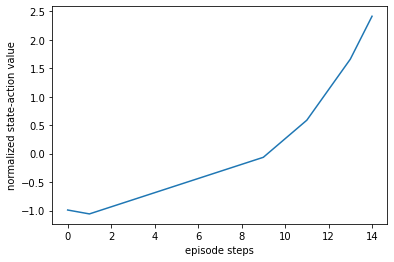

Episode 7, f(w) = -1.76, w = [3.6]
t=0 i=0 action=1
wt_prev=[3.6]
wt_next=[3.5]
f(wt)=-1.250000000000007
rs=[-1.25]
xt_prev=[ 0.   -0.51 -0.51 -5.2  -5.   -5.  ]
xt_next=[ 0.51  0.51  0.   -5.2  -5.2  -5.  ]
f_hist=[-1.250000000000007, -1.7600000000000078, -1.7600000000000078]
g_hist=[array([-5.]), array([-5.2]), array([-5.2])]
w_hist=[array([3.5]), array([3.6]), array([3.6])]
t=1 i=0 action=0
wt_prev=[3.5]
wt_next=[3.5]
f(wt)=-1.250000000000007
rs=[-1.25]
xt_prev=[ 0.51  0.51  0.   -5.2  -5.2  -5.  ]
xt_next=[ 0.    0.51  0.51 -5.   -5.2  -5.2 ]
f_hist=[-1.250000000000007, -1.250000000000007, -1.7600000000000078]
g_hist=[array([-5.]), array([-5.]), array([-5.2])]
w_hist=[array([3.5]), array([3.5]), array([3.6])]
t=2 i=0 action=0
wt_prev=[3.5]
wt_next=[3.5]
f(wt)=-1.250000000000007
rs=[-1.25]
xt_prev=[ 0.    0.51  0.51 -5.   -5.2  -5.2 ]
xt_next=[ 0.    0.    0.51 -5.   -5.   -5.2 ]
f_hist=[-1.250000000000007, -1.250000000000007, -1.250000000000007]
g_hist=[array([-5.]), array([-5.]), 

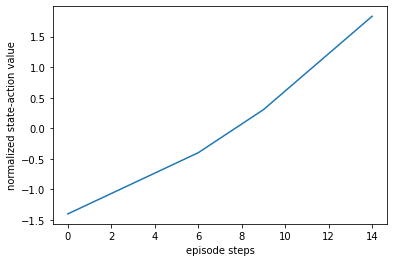

Episode 8, f(w) = -2.29, w = [3.7]
t=0 i=0 action=0
wt_prev=[3.7]
wt_next=[3.7]
f(wt)=-2.290000000000008
rs=[-2.29]
xt_prev=[ 0.   0.   0.  -5.4 -5.4 -5.4]
xt_next=[ 0.   0.   0.  -5.4 -5.4 -5.4]
f_hist=[-2.290000000000008, -2.290000000000008, -2.290000000000008]
g_hist=[array([-5.4]), array([-5.4]), array([-5.4])]
w_hist=[array([3.7]), array([3.7]), array([3.7])]
t=1 i=0 action=0
wt_prev=[3.7]
wt_next=[3.7]
f(wt)=-2.290000000000008
rs=[-2.29]
xt_prev=[ 0.   0.   0.  -5.4 -5.4 -5.4]
xt_next=[ 0.   0.   0.  -5.4 -5.4 -5.4]
f_hist=[-2.290000000000008, -2.290000000000008, -2.290000000000008]
g_hist=[array([-5.4]), array([-5.4]), array([-5.4])]
w_hist=[array([3.7]), array([3.7]), array([3.7])]
t=2 i=0 action=0
wt_prev=[3.7]
wt_next=[3.7]
f(wt)=-2.290000000000008
rs=[-2.29]
xt_prev=[ 0.   0.   0.  -5.4 -5.4 -5.4]
xt_next=[ 0.   0.   0.  -5.4 -5.4 -5.4]
f_hist=[-2.290000000000008, -2.290000000000008, -2.290000000000008]
g_hist=[array([-5.4]), array([-5.4]), array([-5.4])]
w_hist=[array([3.7]

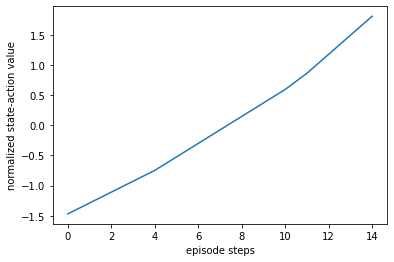

Episode 9, f(w) = -4.00, w = [4.]
t=0 i=0 action=2
wt_prev=[4.]
wt_next=[4.1]
f(wt)=-4.610000000000008
rs=[-4.61]
xt_prev=[ 0.  0.  0. -6. -6. -6.]
xt_next=[-0.61 -0.61 -0.61 -6.   -6.   -6.  ]
f_hist=[-4.610000000000008, -4.000000000000011, -4.000000000000011]
g_hist=[array([-6.2]), array([-6.]), array([-6.])]
w_hist=[array([4.1]), array([4.]), array([4.])]
t=1 i=0 action=0
wt_prev=[4.1]
wt_next=[4.1]
f(wt)=-4.610000000000008
rs=[-4.61]
xt_prev=[-0.61 -0.61 -0.61 -6.   -6.   -6.  ]
xt_next=[ 0.   -0.61 -0.61 -6.2  -6.   -6.  ]
f_hist=[-4.610000000000008, -4.610000000000008, -4.000000000000011]
g_hist=[array([-6.2]), array([-6.2]), array([-6.])]
w_hist=[array([4.1]), array([4.1]), array([4.])]
t=2 i=0 action=2
wt_prev=[4.1]
wt_next=[4.2]
f(wt)=-5.240000000000007
rs=[-5.24]
xt_prev=[ 0.   -0.61 -0.61 -6.2  -6.   -6.  ]
xt_next=[-0.63 -0.63 -1.24 -6.2  -6.2  -6.  ]
f_hist=[-5.240000000000007, -4.610000000000008, -4.610000000000008]
g_hist=[array([-6.4]), array([-6.2]), array([-6.2])]
w_h

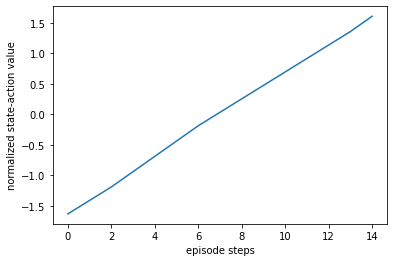

Episode 10, f(w) = -5.24, w = [4.2]


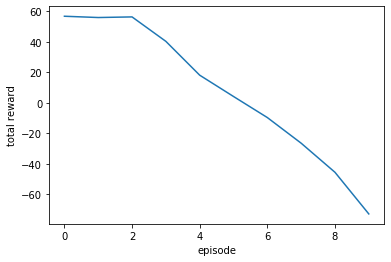

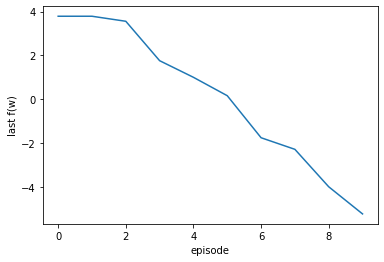

t=0 i=0 action=2
wt_prev=[2.]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
f_hist=[3.79, 4.0, 4.0]
g_hist=[array([-2.2]), array([-2.]), array([-2.])]
w_hist=[array([2.1]), array([2.1]), array([2.1])]
t=1 i=0 action=2
wt_prev=[2.1]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
xt_next=[-0.23 -0.44 -0.44 -2.2  -2.   -2.  ]
f_hist=[3.5599999999999996, 3.79, 4.0]
g_hist=[array([-2.4]), array([-2.2]), array([-2.])]
w_hist=[array([2.2]), array([2.1]), array([2.2])]
t=2 i=0 action=2
wt_prev=[2.2]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[-0.23 -0.44 -0.44 -2.2  -2.   -2.  ]
xt_next=[-0.25 -0.48 -0.69 -2.4  -2.2  -2.  ]
f_hist=[3.3099999999999996, 3.5599999999999996, 3.79]
g_hist=[array([-2.6]), array([-2.4]), array([-2.2])]
w_hist=[array([2.3]), array([2.2]), array([2.1])]
t=3 i=0 action=2
wt_prev=[2.3]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[

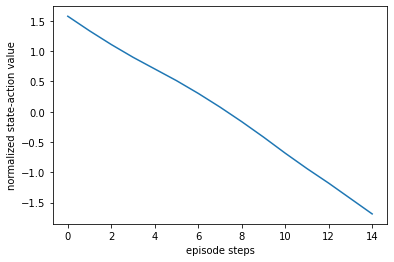

Episode 1, f(w) = 4.00, w = [2.]
t=0 i=0 action=2
wt_prev=[2.]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.    0.    0.21 -2.   -2.   -2.2 ]
xt_next=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
f_hist=[3.79, 4.0, 4.0]
g_hist=[array([-2.2]), array([-2.]), array([-2.])]
w_hist=[array([2.1]), array([2.]), array([2.])]
t=1 i=0 action=2
wt_prev=[2.1]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
xt_next=[-0.23 -0.44 -0.44 -2.2  -2.   -2.  ]
f_hist=[3.5599999999999996, 3.79, 4.0]
g_hist=[array([-2.4]), array([-2.2]), array([-2.])]
w_hist=[array([2.2]), array([2.1]), array([2.])]
t=2 i=0 action=1
wt_prev=[2.2]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[-0.23 -0.44 -0.44 -2.2  -2.   -2.  ]
xt_next=[ 0.23  0.   -0.21 -2.4  -2.2  -2.  ]
f_hist=[3.79, 3.5599999999999996, 3.79]
g_hist=[array([-2.2]), array([-2.4]), array([-2.2])]
w_hist=[array([2.1]), array([2.2]), array([2.1])]
t=3 i=0 action=1
wt_prev=[2.1]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.

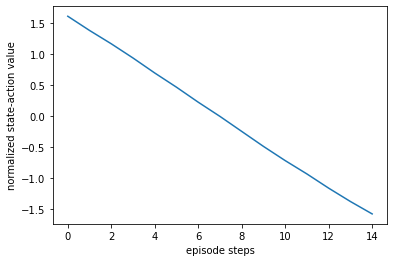

Episode 2, f(w) = 3.04, w = [2.4]
t=0 i=0 action=1
wt_prev=[2.4]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[-0.27 -0.52 -0.75 -2.6  -2.4  -2.2 ]
xt_next=[ 0.27  0.   -0.25 -2.8  -2.6  -2.4 ]
f_hist=[3.3099999999999996, 3.039999999999999, 3.3099999999999996]
g_hist=[array([-2.6]), array([-2.8]), array([-2.6])]
w_hist=[array([2.3]), array([2.4]), array([2.3])]
t=1 i=0 action=2
wt_prev=[2.3]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[ 0.27  0.   -0.25 -2.8  -2.6  -2.4 ]
xt_next=[-0.27  0.   -0.27 -2.6  -2.8  -2.6 ]
f_hist=[3.039999999999999, 3.3099999999999996, 3.039999999999999]
g_hist=[array([-2.8]), array([-2.6]), array([-2.8])]
w_hist=[array([2.4]), array([2.3]), array([2.4])]
t=2 i=0 action=1
wt_prev=[2.4]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[-0.27  0.   -0.27 -2.6  -2.8  -2.6 ]
xt_next=[ 0.27  0.    0.27 -2.8  -2.6  -2.8 ]
f_hist=[3.3099999999999996, 3.039999999999999, 3.3099999999999996]
g_hist=[array([-2.6]), array([-2.8]), array([

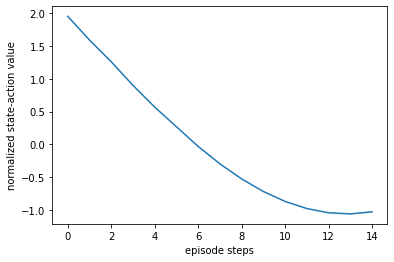

Episode 3, f(w) = 0.16, w = [3.2]
t=0 i=0 action=2
wt_prev=[3.2]
wt_next=[3.3]
f(wt)=-0.29000000000000536
rs=[-0.29]
xt_prev=[ 0.45  0.   -0.43 -4.6  -4.4  -4.2 ]
xt_next=[-0.45  0.   -0.45 -4.4  -4.6  -4.4 ]
f_hist=[-0.29000000000000536, 0.1599999999999957, -0.29000000000000536]
g_hist=[array([-4.6]), array([-4.4]), array([-4.6])]
w_hist=[array([3.3]), array([3.2]), array([3.3])]
t=1 i=0 action=2
wt_prev=[3.3]
wt_next=[3.4]
f(wt)=-0.760000000000006
rs=[-0.76]
xt_prev=[-0.45  0.   -0.45 -4.4  -4.6  -4.4 ]
xt_next=[-0.47 -0.92 -0.47 -4.6  -4.4  -4.6 ]
f_hist=[-0.760000000000006, -0.29000000000000536, 0.1599999999999957]
g_hist=[array([-4.8]), array([-4.6]), array([-4.4])]
w_hist=[array([3.4]), array([3.3]), array([3.2])]
t=2 i=0 action=2
wt_prev=[3.4]
wt_next=[3.5]
f(wt)=-1.250000000000007
rs=[-1.25]
xt_prev=[-0.47 -0.92 -0.47 -4.6  -4.4  -4.6 ]
xt_next=[-0.49 -0.96 -1.41 -4.8  -4.6  -4.4 ]
f_hist=[-1.250000000000007, -0.760000000000006, -0.29000000000000536]
g_hist=[array([-5.]), array

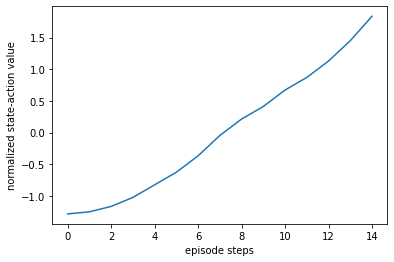

Episode 4, f(w) = -4.00, w = [4.]
t=0 i=0 action=1
wt_prev=[4.]
wt_next=[3.9]
f(wt)=-3.410000000000009
rs=[-3.41]
xt_prev=[-0.59 -1.16 -1.71 -5.8  -5.6  -5.4 ]
xt_next=[ 0.59  0.   -0.57 -6.   -5.8  -5.6 ]
f_hist=[-3.410000000000009, -4.000000000000011, -3.410000000000009]
g_hist=[array([-5.8]), array([-6.]), array([-5.8])]
w_hist=[array([3.9]), array([4.]), array([3.9])]
t=1 i=0 action=1
wt_prev=[3.9]
wt_next=[3.8]
f(wt)=-2.8400000000000087
rs=[-2.84]
xt_prev=[ 0.59  0.   -0.57 -6.   -5.8  -5.6 ]
xt_next=[ 0.57  1.16  0.57 -5.8  -6.   -5.8 ]
f_hist=[-2.8400000000000087, -3.410000000000009, -4.000000000000011]
g_hist=[array([-5.6]), array([-5.8]), array([-6.])]
w_hist=[array([3.8]), array([3.9]), array([4.])]
t=2 i=0 action=2
wt_prev=[3.8]
wt_next=[3.9]
f(wt)=-3.410000000000009
rs=[-3.41]
xt_prev=[ 0.57  1.16  0.57 -5.8  -6.   -5.8 ]
xt_next=[-0.57  0.    0.59 -5.6  -5.8  -6.  ]
f_hist=[-3.410000000000009, -2.8400000000000087, -3.410000000000009]
g_hist=[array([-5.8]), array([-5.6]), a

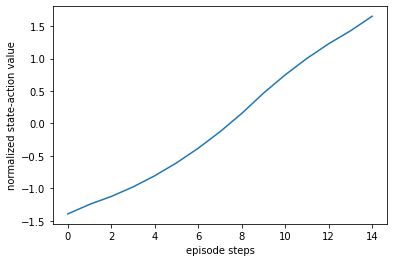

Episode 5, f(w) = -4.61, w = [4.1]
t=0 i=0 action=1
wt_prev=[4.1]
wt_next=[4.]
f(wt)=-4.000000000000011
rs=[-4.]
xt_prev=[ 0.63  0.    0.63 -6.4  -6.2  -6.4 ]
xt_next=[ 0.61  1.24  0.61 -6.2  -6.4  -6.2 ]
f_hist=[-4.000000000000011, -4.610000000000008, -5.240000000000007]
g_hist=[array([-6.]), array([-6.2]), array([-6.4])]
w_hist=[array([4.]), array([4.1]), array([4.2])]
t=1 i=0 action=2
wt_prev=[4.]
wt_next=[4.1]
f(wt)=-4.610000000000008
rs=[-4.61]
xt_prev=[ 0.61  1.24  0.61 -6.2  -6.4  -6.2 ]
xt_next=[-0.61  0.    0.63 -6.   -6.2  -6.4 ]
f_hist=[-4.610000000000008, -4.000000000000011, -4.610000000000008]
g_hist=[array([-6.2]), array([-6.]), array([-6.2])]
w_hist=[array([4.1]), array([4.]), array([4.1])]
t=2 i=0 action=2
wt_prev=[4.1]
wt_next=[4.2]
f(wt)=-5.240000000000007
rs=[-5.24]
xt_prev=[-0.61  0.    0.63 -6.   -6.2  -6.4 ]
xt_next=[-0.63 -1.24 -0.63 -6.2  -6.   -6.2 ]
f_hist=[-5.240000000000007, -4.610000000000008, -4.000000000000011]
g_hist=[array([-6.4]), array([-6.2]), array(

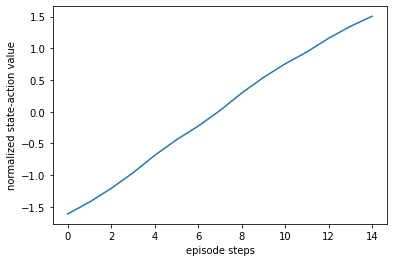

Episode 6, f(w) = -2.84, w = [3.8]
t=0 i=0 action=1
wt_prev=[3.8]
wt_next=[3.7]
f(wt)=-2.290000000000008
rs=[-2.29]
xt_prev=[ 0.57  1.16  1.77 -5.8  -6.   -6.2 ]
xt_next=[ 0.55  1.12  1.71 -5.6  -5.8  -6.  ]
f_hist=[-2.290000000000008, -2.8400000000000087, -3.410000000000009]
g_hist=[array([-5.4]), array([-5.6]), array([-5.8])]
w_hist=[array([3.7]), array([3.8]), array([3.9])]
t=1 i=0 action=2
wt_prev=[3.7]
wt_next=[3.8]
f(wt)=-2.8400000000000087
rs=[-2.84]
xt_prev=[ 0.55  1.12  1.71 -5.6  -5.8  -6.  ]
xt_next=[-0.55  0.    0.57 -5.4  -5.6  -5.8 ]
f_hist=[-2.8400000000000087, -2.290000000000008, -2.8400000000000087]
g_hist=[array([-5.6]), array([-5.4]), array([-5.6])]
w_hist=[array([3.8]), array([3.7]), array([3.8])]
t=2 i=0 action=1
wt_prev=[3.8]
wt_next=[3.7]
f(wt)=-2.290000000000008
rs=[-2.29]
xt_prev=[-0.55  0.    0.57 -5.4  -5.6  -5.8 ]
xt_next=[ 0.55  0.    0.55 -5.6  -5.4  -5.6 ]
f_hist=[-2.290000000000008, -2.8400000000000087, -2.290000000000008]
g_hist=[array([-5.4]), array([-

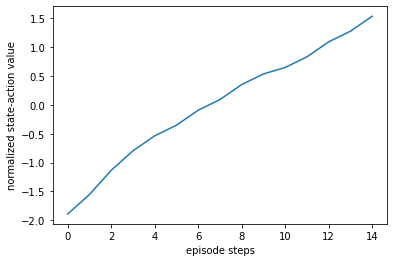

Episode 7, f(w) = -1.25, w = [3.5]
t=0 i=0 action=2
wt_prev=[3.5]
wt_next=[3.6]
f(wt)=-1.7600000000000078
rs=[-1.76]
xt_prev=[ 0.51  0.    0.51 -5.2  -5.   -5.2 ]
xt_next=[-0.51  0.   -0.51 -5.   -5.2  -5.  ]
f_hist=[-1.7600000000000078, -1.250000000000007, -1.7600000000000078]
g_hist=[array([-5.2]), array([-5.]), array([-5.2])]
w_hist=[array([3.6]), array([3.5]), array([3.6])]
t=1 i=0 action=1
wt_prev=[3.6]
wt_next=[3.5]
f(wt)=-1.250000000000007
rs=[-1.25]
xt_prev=[-0.51  0.   -0.51 -5.   -5.2  -5.  ]
xt_next=[ 0.51  0.    0.51 -5.2  -5.   -5.2 ]
f_hist=[-1.250000000000007, -1.7600000000000078, -1.250000000000007]
g_hist=[array([-5.]), array([-5.2]), array([-5.])]
w_hist=[array([3.5]), array([3.6]), array([3.5])]
t=2 i=0 action=1
wt_prev=[3.5]
wt_next=[3.4]
f(wt)=-0.760000000000006
rs=[-0.76]
xt_prev=[ 0.51  0.    0.51 -5.2  -5.   -5.2 ]
xt_next=[ 0.49  1.    0.49 -5.   -5.2  -5.  ]
f_hist=[-0.760000000000006, -1.250000000000007, -1.7600000000000078]
g_hist=[array([-4.8]), array([-5.]

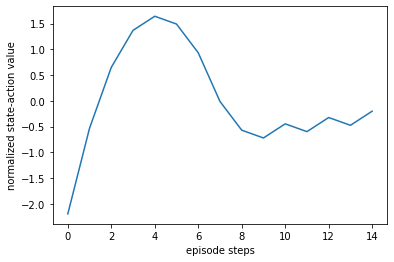

Episode 8, f(w) = 0.16, w = [3.2]
t=0 i=0 action=1
wt_prev=[3.2]
wt_next=[3.1]
f(wt)=0.5899999999999963
rs=[0.59]
xt_prev=[ 0.45  0.    0.45 -4.6  -4.4  -4.6 ]
xt_next=[ 0.43  0.88  0.43 -4.4  -4.6  -4.4 ]
f_hist=[0.5899999999999963, 0.1599999999999957, -0.29000000000000536]
g_hist=[array([-4.2]), array([-4.4]), array([-4.6])]
w_hist=[array([3.1]), array([3.2]), array([3.3])]
t=1 i=0 action=1
wt_prev=[3.1]
wt_next=[3.]
f(wt)=0.9999999999999964
rs=[1.]
xt_prev=[ 0.43  0.88  0.43 -4.4  -4.6  -4.4 ]
xt_next=[ 0.41  0.84  1.29 -4.2  -4.4  -4.6 ]
f_hist=[0.9999999999999964, 0.5899999999999963, 0.1599999999999957]
g_hist=[array([-4.]), array([-4.2]), array([-4.4])]
w_hist=[array([3.]), array([3.1]), array([3.2])]
t=2 i=0 action=1
wt_prev=[3.]
wt_next=[2.9]
f(wt)=1.389999999999997
rs=[1.39]
xt_prev=[ 0.41  0.84  1.29 -4.2  -4.4  -4.6 ]
xt_next=[ 0.39  0.8   1.23 -4.   -4.2  -4.4 ]
f_hist=[1.389999999999997, 0.9999999999999964, 0.5899999999999963]
g_hist=[array([-3.8]), array([-4.]), array([-4

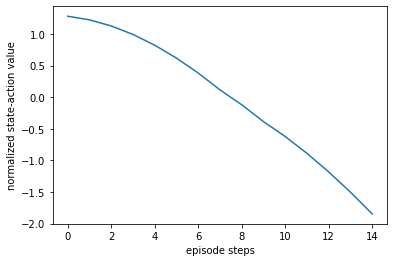

Episode 9, f(w) = 3.31, w = [2.3]
t=0 i=0 action=1
wt_prev=[2.3]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.25  0.    0.27 -2.4  -2.6  -2.8 ]
xt_next=[ 0.25  0.    0.25 -2.6  -2.4  -2.6 ]
f_hist=[3.5599999999999996, 3.3099999999999996, 3.5599999999999996]
g_hist=[array([-2.4]), array([-2.6]), array([-2.4])]
w_hist=[array([2.2]), array([2.3]), array([2.2])]
t=1 i=0 action=2
wt_prev=[2.2]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[ 0.25  0.    0.25 -2.6  -2.4  -2.6 ]
xt_next=[-0.25  0.   -0.25 -2.4  -2.6  -2.4 ]
f_hist=[3.3099999999999996, 3.5599999999999996, 3.3099999999999996]
g_hist=[array([-2.6]), array([-2.4]), array([-2.6])]
w_hist=[array([2.3]), array([2.2]), array([2.3])]
t=2 i=0 action=1
wt_prev=[2.3]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.25  0.   -0.25 -2.4  -2.6  -2.4 ]
xt_next=[ 0.25  0.    0.25 -2.6  -2.4  -2.6 ]
f_hist=[3.5599999999999996, 3.3099999999999996, 3.5599999999999996]
g_hist=[array([-2.4]), array([-2.6]), ar

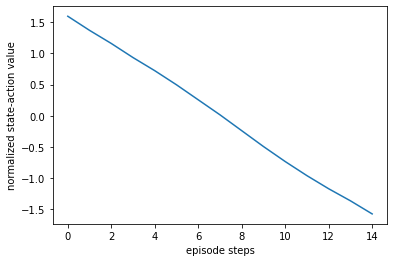

Episode 10, f(w) = 3.56, w = [2.2]


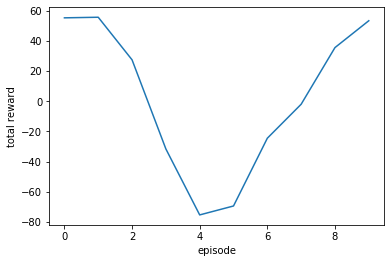

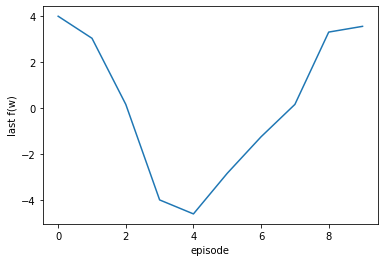

t=0 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[ 0.  0.  0. -2. -2. -2.]
f_hist=[4.0, 4.0, 4.0]
g_hist=[array([-2.]), array([-2.]), array([-2.])]
w_hist=[array([2.]), array([2.]), array([2.])]
t=1 i=0 action=1
wt_prev=[2.]
wt_next=[1.9]
f(wt)=4.19
rs=[4.19]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[ 0.19  0.19  0.19 -2.   -2.   -2.  ]
f_hist=[4.19, 4.0, 4.0]
g_hist=[array([-1.8]), array([-2.]), array([-2.])]
w_hist=[array([1.9]), array([2.]), array([1.9])]
t=2 i=0 action=2
wt_prev=[1.9]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.19  0.19  0.19 -2.   -2.   -2.  ]
xt_next=[-0.19  0.    0.   -1.8  -2.   -2.  ]
f_hist=[4.0, 4.19, 4.0]
g_hist=[array([-2.]), array([-1.8]), array([-2.])]
w_hist=[array([2.]), array([1.9]), array([2.])]
t=3 i=0 action=2
wt_prev=[2.]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[-0.19  0.    0.   -1.8  -2.   -2.  ]
xt_next=[-0.21 -0.4  -0.21 -2.   -1.8  -2.  ]
f_hist=[3.79, 4.0, 4.19]
g_hist=[array([-2.2]), 

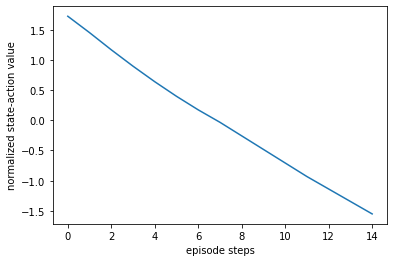

Episode 1, f(w) = 2.75, w = [2.5]
t=0 i=0 action=1
wt_prev=[2.5]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[-0.29 -0.29 -0.29 -2.8  -2.8  -2.8 ]
xt_next=[ 0.29  0.    0.   -3.   -2.8  -2.8 ]
f_hist=[3.039999999999999, 2.7499999999999987, 3.039999999999999]
g_hist=[array([-2.8]), array([-3.]), array([-2.8])]
w_hist=[array([2.4]), array([2.5]), array([2.4])]
t=1 i=0 action=2
wt_prev=[2.4]
wt_next=[2.5]
f(wt)=2.7499999999999987
rs=[2.75]
xt_prev=[ 0.29  0.    0.   -3.   -2.8  -2.8 ]
xt_next=[-0.29  0.   -0.29 -2.8  -3.   -2.8 ]
f_hist=[2.7499999999999987, 3.039999999999999, 2.7499999999999987]
g_hist=[array([-3.]), array([-2.8]), array([-3.])]
w_hist=[array([2.5]), array([2.4]), array([2.5])]
t=2 i=0 action=0
wt_prev=[2.5]
wt_next=[2.5]
f(wt)=2.7499999999999987
rs=[2.75]
xt_prev=[-0.29  0.   -0.29 -2.8  -3.   -2.8 ]
xt_next=[ 0.   -0.29  0.   -3.   -2.8  -3.  ]
f_hist=[2.7499999999999987, 2.7499999999999987, 3.039999999999999]
g_hist=[array([-3.]), array([-3.]), array([-2.8]

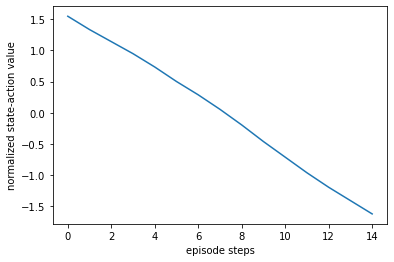

Episode 2, f(w) = 3.31, w = [2.3]
t=0 i=0 action=1
wt_prev=[2.3]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[ 0.27  0.27  0.   -2.8  -2.8  -2.6 ]
xt_next=[ 0.25  0.52  0.52 -2.6  -2.8  -2.8 ]
f_hist=[3.5599999999999996, 3.3099999999999996, 3.039999999999999]
g_hist=[array([-2.4]), array([-2.6]), array([-2.8])]
w_hist=[array([2.2]), array([2.3]), array([2.4])]
t=1 i=0 action=2
wt_prev=[2.2]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[ 0.25  0.52  0.52 -2.6  -2.8  -2.8 ]
xt_next=[-0.25  0.    0.27 -2.4  -2.6  -2.8 ]
f_hist=[3.3099999999999996, 3.5599999999999996, 3.3099999999999996]
g_hist=[array([-2.6]), array([-2.4]), array([-2.6])]
w_hist=[array([2.3]), array([2.2]), array([2.3])]
t=2 i=0 action=1
wt_prev=[2.3]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.25  0.    0.27 -2.4  -2.6  -2.8 ]
xt_next=[ 0.25  0.    0.25 -2.6  -2.4  -2.6 ]
f_hist=[3.5599999999999996, 3.3099999999999996, 3.5599999999999996]
g_hist=[array([-2.4]), array([-2.6]), arr

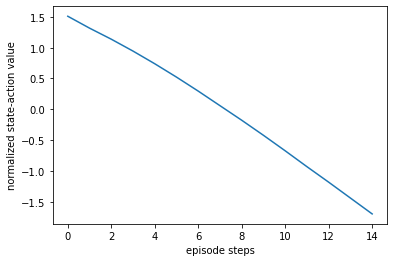

Episode 3, f(w) = 4.84, w = [1.4]
t=0 i=0 action=2
wt_prev=[1.4]
wt_next=[1.5]
f(wt)=4.75
rs=[4.75]
xt_prev=[ 0.09  0.09  0.2  -1.   -1.   -1.2 ]
xt_next=[-0.09  0.    0.   -0.8  -1.   -1.  ]
f_hist=[4.75, 4.840000000000001, 4.75]
g_hist=[array([-1.]), array([-0.8]), array([-1.])]
w_hist=[array([1.5]), array([1.4]), array([1.5])]
t=1 i=0 action=2
wt_prev=[1.5]
wt_next=[1.6]
f(wt)=4.640000000000001
rs=[4.64]
xt_prev=[-0.09  0.    0.   -0.8  -1.   -1.  ]
xt_next=[-0.11 -0.2  -0.11 -1.   -0.8  -1.  ]
f_hist=[4.640000000000001, 4.75, 4.840000000000001]
g_hist=[array([-1.2]), array([-1.]), array([-0.8])]
w_hist=[array([1.6]), array([1.5]), array([1.4])]
t=2 i=0 action=2
wt_prev=[1.6]
wt_next=[1.7]
f(wt)=4.510000000000001
rs=[4.51]
xt_prev=[-0.11 -0.2  -0.11 -1.   -0.8  -1.  ]
xt_next=[-0.13 -0.24 -0.33 -1.2  -1.   -0.8 ]
f_hist=[4.510000000000001, 4.640000000000001, 4.75]
g_hist=[array([-1.4]), array([-1.2]), array([-1.])]
w_hist=[array([1.7]), array([1.6]), array([1.5])]
t=3 i=0 action=2
w

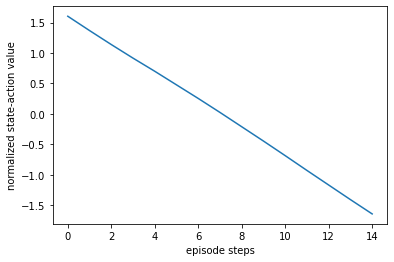

Episode 4, f(w) = 4.84, w = [1.4]
t=0 i=0 action=1
wt_prev=[1.4]
wt_next=[1.3]
f(wt)=4.91
rs=[4.91]
xt_prev=[ 0.09  0.    0.   -1.   -0.8  -0.8 ]
xt_next=[ 0.07  0.16  0.07 -0.8  -1.   -0.8 ]
f_hist=[4.91, 4.840000000000001, 4.75]
g_hist=[array([-0.6]), array([-0.8]), array([-1.])]
w_hist=[array([1.3]), array([1.4]), array([1.5])]
t=1 i=0 action=1
wt_prev=[1.3]
wt_next=[1.2]
f(wt)=4.96
rs=[4.96]
xt_prev=[ 0.07  0.16  0.07 -0.8  -1.   -0.8 ]
xt_next=[ 0.05  0.12  0.21 -0.6  -0.8  -1.  ]
f_hist=[4.96, 4.91, 4.840000000000001]
g_hist=[array([-0.4]), array([-0.6]), array([-0.8])]
w_hist=[array([1.2]), array([1.3]), array([1.4])]
t=2 i=0 action=0
wt_prev=[1.2]
wt_next=[1.2]
f(wt)=4.96
rs=[4.96]
xt_prev=[ 0.05  0.12  0.21 -0.6  -0.8  -1.  ]
xt_next=[ 0.    0.05  0.12 -0.4  -0.6  -0.8 ]
f_hist=[4.96, 4.96, 4.91]
g_hist=[array([-0.4]), array([-0.4]), array([-0.6])]
w_hist=[array([1.2]), array([1.2]), array([1.3])]
t=3 i=0 action=1
wt_prev=[1.2]
wt_next=[1.1]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.  

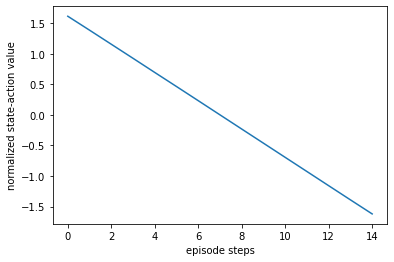

Episode 5, f(w) = 4.99, w = [1.1]
t=0 i=0 action=0
wt_prev=[1.1]
wt_next=[1.1]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 3.00000000e-02  0.00000000e+00 -1.00000000e-02 -4.00000000e-01
 -2.00000000e-01  1.55431223e-15]
xt_next=[ 0.    0.03  0.   -0.2  -0.4  -0.2 ]
f_hist=[4.99, 4.99, 4.96]
g_hist=[array([-0.2]), array([-0.2]), array([-0.4])]
w_hist=[array([1.1]), array([1.1]), array([1.2])]
t=1 i=0 action=0
wt_prev=[1.1]
wt_next=[1.1]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.    0.03  0.   -0.2  -0.4  -0.2 ]
xt_next=[ 0.    0.    0.03 -0.2  -0.2  -0.4 ]
f_hist=[4.99, 4.99, 4.99]
g_hist=[array([-0.2]), array([-0.2]), array([-0.2])]
w_hist=[array([1.1]), array([1.1]), array([1.1])]
t=2 i=0 action=0
wt_prev=[1.1]
wt_next=[1.1]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.    0.    0.03 -0.2  -0.2  -0.4 ]
xt_next=[ 0.   0.   0.  -0.2 -0.2 -0.2]
f_hist=[4.99, 4.99, 4.99]
g_hist=[array([-0.2]), array([-0.2]), array([-0.2])]
w_hist=[array([1.1]), array([1.1]), array([1.1])]
t=3 i=0 action=1
wt_prev=[1.1]
wt_next=[1.]
f(wt)=

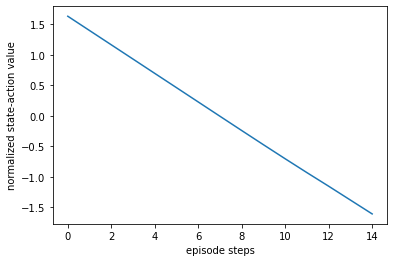

Episode 6, f(w) = 4.91, w = [1.3]
t=0 i=0 action=1
wt_prev=[1.3]
wt_next=[1.2]
f(wt)=4.96
rs=[4.96]
xt_prev=[ 0.07  0.07  0.16 -0.8  -0.8  -1.  ]
xt_next=[ 0.05  0.12  0.12 -0.6  -0.8  -0.8 ]
f_hist=[4.96, 4.91, 4.840000000000001]
g_hist=[array([-0.4]), array([-0.6]), array([-0.8])]
w_hist=[array([1.2]), array([1.3]), array([1.4])]
t=1 i=0 action=2
wt_prev=[1.2]
wt_next=[1.3]
f(wt)=4.91
rs=[4.91]
xt_prev=[ 0.05  0.12  0.12 -0.6  -0.8  -0.8 ]
xt_next=[-0.05  0.    0.07 -0.4  -0.6  -0.8 ]
f_hist=[4.91, 4.96, 4.91]
g_hist=[array([-0.6]), array([-0.4]), array([-0.6])]
w_hist=[array([1.3]), array([1.2]), array([1.3])]
t=2 i=0 action=1
wt_prev=[1.3]
wt_next=[1.2]
f(wt)=4.96
rs=[4.96]
xt_prev=[-0.05  0.    0.07 -0.4  -0.6  -0.8 ]
xt_next=[ 0.05  0.    0.05 -0.6  -0.4  -0.6 ]
f_hist=[4.96, 4.91, 4.96]
g_hist=[array([-0.4]), array([-0.6]), array([-0.4])]
w_hist=[array([1.2]), array([1.3]), array([1.2])]
t=3 i=0 action=1
wt_prev=[1.2]
wt_next=[1.1]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.05  0.    0.05

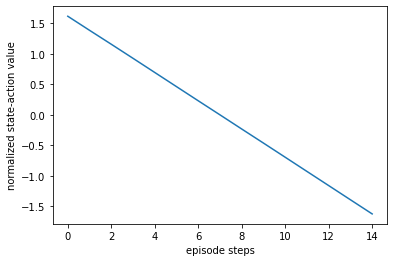

Episode 7, f(w) = 4.99, w = [0.9]
t=0 i=0 action=1
wt_prev=[0.9]
wt_next=[0.8]
f(wt)=4.96
rs=[4.96]
xt_prev=[ 0.00000000e+00 -1.00000000e-02  0.00000000e+00  2.00000000e-01
  1.55431223e-15  2.00000000e-01]
xt_next=[-3.00000000e-02 -3.00000000e-02 -4.00000000e-02  2.00000000e-01
  2.00000000e-01  1.55431223e-15]
f_hist=[4.96, 4.99, 4.99]
g_hist=[array([0.4]), array([0.2]), array([0.2])]
w_hist=[array([0.8]), array([0.9]), array([0.9])]
t=1 i=0 action=1
wt_prev=[0.8]
wt_next=[0.7]
f(wt)=4.909999999999999
rs=[4.91]
xt_prev=[-3.00000000e-02 -3.00000000e-02 -4.00000000e-02  2.00000000e-01
  2.00000000e-01  1.55431223e-15]
xt_next=[-0.05 -0.08 -0.08  0.4   0.2   0.2 ]
f_hist=[4.909999999999999, 4.96, 4.99]
g_hist=[array([0.6]), array([0.4]), array([0.2])]
w_hist=[array([0.7]), array([0.8]), array([0.9])]
t=2 i=0 action=2
wt_prev=[0.7]
wt_next=[0.8]
f(wt)=4.96
rs=[4.96]
xt_prev=[-0.05 -0.08 -0.08  0.4   0.2   0.2 ]
xt_next=[ 0.05  0.   -0.03  0.6   0.4   0.2 ]
f_hist=[4.96, 4.909999999999999

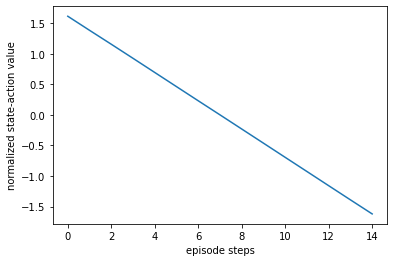

Episode 8, f(w) = 4.96, w = [1.2]
t=0 i=0 action=1
wt_prev=[1.2]
wt_next=[1.1]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.00000000e+00 -3.00000000e-02 -4.00000000e-02 -4.00000000e-01
 -2.00000000e-01  1.55431223e-15]
xt_next=[ 0.03  0.03  0.   -0.4  -0.4  -0.2 ]
f_hist=[4.99, 4.96, 4.96]
g_hist=[array([-0.2]), array([-0.4]), array([-0.4])]
w_hist=[array([1.1]), array([1.2]), array([1.2])]
t=1 i=0 action=2
wt_prev=[1.1]
wt_next=[1.2]
f(wt)=4.96
rs=[4.96]
xt_prev=[ 0.03  0.03  0.   -0.4  -0.4  -0.2 ]
xt_next=[-0.03  0.    0.   -0.2  -0.4  -0.4 ]
f_hist=[4.96, 4.99, 4.96]
g_hist=[array([-0.4]), array([-0.2]), array([-0.4])]
w_hist=[array([1.2]), array([1.1]), array([1.2])]
t=2 i=0 action=2
wt_prev=[1.2]
wt_next=[1.3]
f(wt)=4.91
rs=[4.91]
xt_prev=[-0.03  0.    0.   -0.2  -0.4  -0.4 ]
xt_next=[-0.05 -0.08 -0.05 -0.4  -0.2  -0.4 ]
f_hist=[4.91, 4.96, 4.99]
g_hist=[array([-0.6]), array([-0.4]), array([-0.2])]
w_hist=[array([1.3]), array([1.2]), array([1.1])]
t=3 i=0 action=2
wt_prev=[1.3]
wt_next=[1.4]

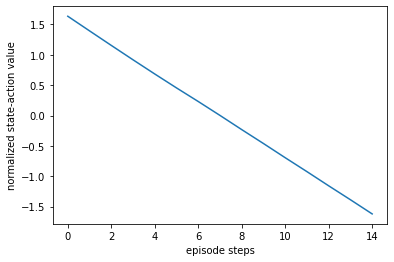

Episode 9, f(w) = 4.75, w = [1.5]
t=0 i=0 action=1
wt_prev=[1.5]
wt_next=[1.4]
f(wt)=4.840000000000001
rs=[4.84]
xt_prev=[-0.09  0.   -0.09 -0.8  -1.   -0.8 ]
xt_next=[ 0.09  0.    0.09 -1.   -0.8  -1.  ]
f_hist=[4.840000000000001, 4.75, 4.840000000000001]
g_hist=[array([-0.8]), array([-1.]), array([-0.8])]
w_hist=[array([1.4]), array([1.5]), array([1.4])]
t=1 i=0 action=2
wt_prev=[1.4]
wt_next=[1.5]
f(wt)=4.75
rs=[4.75]
xt_prev=[ 0.09  0.    0.09 -1.   -0.8  -1.  ]
xt_next=[-0.09  0.   -0.09 -0.8  -1.   -0.8 ]
f_hist=[4.75, 4.840000000000001, 4.75]
g_hist=[array([-1.]), array([-0.8]), array([-1.])]
w_hist=[array([1.5]), array([1.4]), array([1.5])]
t=2 i=0 action=1
wt_prev=[1.5]
wt_next=[1.4]
f(wt)=4.840000000000001
rs=[4.84]
xt_prev=[-0.09  0.   -0.09 -0.8  -1.   -0.8 ]
xt_next=[ 0.09  0.    0.09 -1.   -0.8  -1.  ]
f_hist=[4.840000000000001, 4.75, 4.840000000000001]
g_hist=[array([-0.8]), array([-1.]), array([-0.8])]
w_hist=[array([1.4]), array([1.5]), array([1.4])]
t=3 i=0 action=1
w

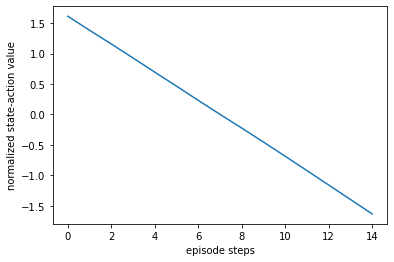

Episode 10, f(w) = 5.00, w = [1.]


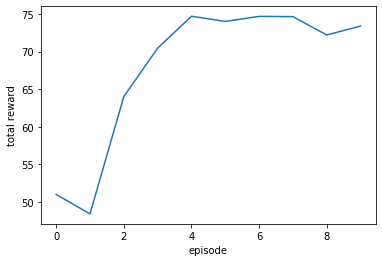

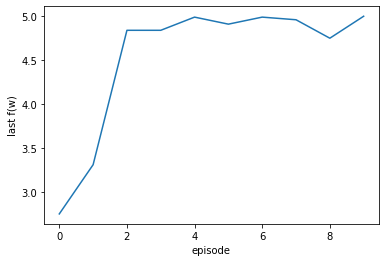

t=0 i=0 action=2
wt_prev=[2.]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
f_hist=[3.79, 4.0, 4.0]
g_hist=[array([-2.2]), array([-2.]), array([-2.])]
w_hist=[array([2.1]), array([2.1]), array([2.1])]
t=1 i=0 action=2
wt_prev=[2.1]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
xt_next=[-0.23 -0.44 -0.44 -2.2  -2.   -2.  ]
f_hist=[3.5599999999999996, 3.79, 4.0]
g_hist=[array([-2.4]), array([-2.2]), array([-2.])]
w_hist=[array([2.2]), array([2.1]), array([2.2])]
t=2 i=0 action=0
wt_prev=[2.2]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.23 -0.44 -0.44 -2.2  -2.   -2.  ]
xt_next=[ 0.   -0.23 -0.44 -2.4  -2.2  -2.  ]
f_hist=[3.5599999999999996, 3.5599999999999996, 3.79]
g_hist=[array([-2.4]), array([-2.4]), array([-2.2])]
w_hist=[array([2.2]), array([2.2]), array([2.1])]
t=3 i=0 action=0
wt_prev=[2.2]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=

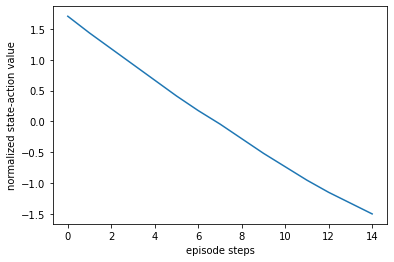

Episode 1, f(w) = 2.44, w = [2.6]
t=0 i=0 action=2
wt_prev=[2.6]
wt_next=[2.7]
f(wt)=2.109999999999998
rs=[2.11]
xt_prev=[ 0.    0.   -0.31 -3.2  -3.2  -3.  ]
xt_next=[-0.33 -0.33 -0.33 -3.2  -3.2  -3.2 ]
f_hist=[2.109999999999998, 2.439999999999998, 2.439999999999998]
g_hist=[array([-3.4]), array([-3.2]), array([-3.2])]
w_hist=[array([2.7]), array([2.6]), array([2.6])]
t=1 i=0 action=0
wt_prev=[2.7]
wt_next=[2.7]
f(wt)=2.109999999999998
rs=[2.11]
xt_prev=[-0.33 -0.33 -0.33 -3.2  -3.2  -3.2 ]
xt_next=[ 0.   -0.33 -0.33 -3.4  -3.2  -3.2 ]
f_hist=[2.109999999999998, 2.109999999999998, 2.439999999999998]
g_hist=[array([-3.4]), array([-3.4]), array([-3.2])]
w_hist=[array([2.7]), array([2.7]), array([2.6])]
t=2 i=0 action=0
wt_prev=[2.7]
wt_next=[2.7]
f(wt)=2.109999999999998
rs=[2.11]
xt_prev=[ 0.   -0.33 -0.33 -3.4  -3.2  -3.2 ]
xt_next=[ 0.    0.   -0.33 -3.4  -3.4  -3.2 ]
f_hist=[2.109999999999998, 2.109999999999998, 2.109999999999998]
g_hist=[array([-3.4]), array([-3.4]), array([-3.4])]

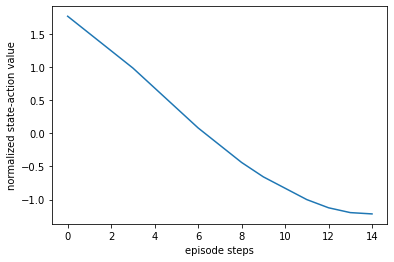

Episode 2, f(w) = -0.29, w = [3.3]
t=0 i=0 action=0
wt_prev=[3.3]
wt_next=[3.3]
f(wt)=-0.29000000000000536
rs=[-0.29]
xt_prev=[-0.45 -0.88 -1.29 -4.4  -4.2  -4.  ]
xt_next=[ 0.   -0.45 -0.88 -4.6  -4.4  -4.2 ]
f_hist=[-0.29000000000000536, -0.29000000000000536, 0.1599999999999957]
g_hist=[array([-4.6]), array([-4.6]), array([-4.4])]
w_hist=[array([3.3]), array([3.3]), array([3.2])]
t=1 i=0 action=2
wt_prev=[3.3]
wt_next=[3.4]
f(wt)=-0.760000000000006
rs=[-0.76]
xt_prev=[ 0.   -0.45 -0.88 -4.6  -4.4  -4.2 ]
xt_next=[-0.47 -0.47 -0.92 -4.6  -4.6  -4.4 ]
f_hist=[-0.760000000000006, -0.29000000000000536, -0.29000000000000536]
g_hist=[array([-4.8]), array([-4.6]), array([-4.6])]
w_hist=[array([3.4]), array([3.3]), array([3.3])]
t=2 i=0 action=2
wt_prev=[3.4]
wt_next=[3.5]
f(wt)=-1.250000000000007
rs=[-1.25]
xt_prev=[-0.47 -0.47 -0.92 -4.6  -4.6  -4.4 ]
xt_next=[-0.49 -0.96 -0.96 -4.8  -4.6  -4.6 ]
f_hist=[-1.250000000000007, -0.760000000000006, -0.29000000000000536]
g_hist=[array([-5.]), ar

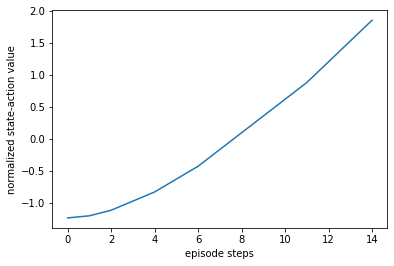

Episode 3, f(w) = -2.84, w = [3.8]
t=0 i=0 action=0
wt_prev=[3.8]
wt_next=[3.8]
f(wt)=-2.8400000000000087
rs=[-2.84]
xt_prev=[ 0.   0.   0.  -5.6 -5.6 -5.6]
xt_next=[ 0.   0.   0.  -5.6 -5.6 -5.6]
f_hist=[-2.8400000000000087, -2.8400000000000087, -2.8400000000000087]
g_hist=[array([-5.6]), array([-5.6]), array([-5.6])]
w_hist=[array([3.8]), array([3.8]), array([3.8])]
t=1 i=0 action=0
wt_prev=[3.8]
wt_next=[3.8]
f(wt)=-2.8400000000000087
rs=[-2.84]
xt_prev=[ 0.   0.   0.  -5.6 -5.6 -5.6]
xt_next=[ 0.   0.   0.  -5.6 -5.6 -5.6]
f_hist=[-2.8400000000000087, -2.8400000000000087, -2.8400000000000087]
g_hist=[array([-5.6]), array([-5.6]), array([-5.6])]
w_hist=[array([3.8]), array([3.8]), array([3.8])]
t=2 i=0 action=0
wt_prev=[3.8]
wt_next=[3.8]
f(wt)=-2.8400000000000087
rs=[-2.84]
xt_prev=[ 0.   0.   0.  -5.6 -5.6 -5.6]
xt_next=[ 0.   0.   0.  -5.6 -5.6 -5.6]
f_hist=[-2.8400000000000087, -2.8400000000000087, -2.8400000000000087]
g_hist=[array([-5.6]), array([-5.6]), array([-5.6])]
w_hist=

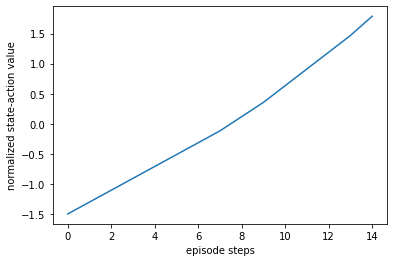

Episode 4, f(w) = -4.61, w = [4.1]
t=0 i=0 action=0
wt_prev=[4.1]
wt_next=[4.1]
f(wt)=-4.610000000000008
rs=[-4.61]
xt_prev=[ 0.   -0.61 -0.61 -6.2  -6.   -6.  ]
xt_next=[ 0.    0.   -0.61 -6.2  -6.2  -6.  ]
f_hist=[-4.610000000000008, -4.610000000000008, -4.610000000000008]
g_hist=[array([-6.2]), array([-6.2]), array([-6.2])]
w_hist=[array([4.1]), array([4.1]), array([4.1])]
t=1 i=0 action=1
wt_prev=[4.1]
wt_next=[4.]
f(wt)=-4.000000000000011
rs=[-4.]
xt_prev=[ 0.    0.   -0.61 -6.2  -6.2  -6.  ]
xt_next=[ 0.61  0.61  0.61 -6.2  -6.2  -6.2 ]
f_hist=[-4.000000000000011, -4.610000000000008, -4.610000000000008]
g_hist=[array([-6.]), array([-6.2]), array([-6.2])]
w_hist=[array([4.]), array([4.1]), array([4.1])]
t=2 i=0 action=0
wt_prev=[4.]
wt_next=[4.]
f(wt)=-4.000000000000011
rs=[-4.]
xt_prev=[ 0.61  0.61  0.61 -6.2  -6.2  -6.2 ]
xt_next=[ 0.    0.61  0.61 -6.   -6.2  -6.2 ]
f_hist=[-4.000000000000011, -4.000000000000011, -4.610000000000008]
g_hist=[array([-6.]), array([-6.]), array([-6

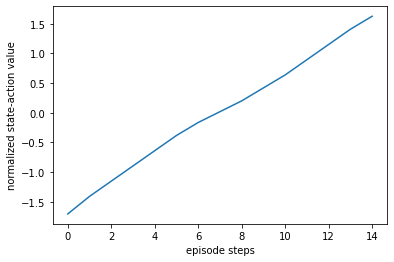

Episode 5, f(w) = -2.84, w = [3.8]
t=0 i=0 action=2
wt_prev=[3.8]
wt_next=[3.9]
f(wt)=-3.410000000000009
rs=[-3.41]
xt_prev=[ 0.57  1.16  1.16 -5.8  -6.   -6.  ]
xt_next=[-0.57  0.    0.59 -5.6  -5.8  -6.  ]
f_hist=[-3.410000000000009, -2.8400000000000087, -3.410000000000009]
g_hist=[array([-5.8]), array([-5.6]), array([-5.8])]
w_hist=[array([3.9]), array([3.8]), array([3.9])]
t=1 i=0 action=0
wt_prev=[3.9]
wt_next=[3.9]
f(wt)=-3.410000000000009
rs=[-3.41]
xt_prev=[-0.57  0.    0.59 -5.6  -5.8  -6.  ]
xt_next=[ 0.   -0.57  0.   -5.8  -5.6  -5.8 ]
f_hist=[-3.410000000000009, -3.410000000000009, -2.8400000000000087]
g_hist=[array([-5.8]), array([-5.8]), array([-5.6])]
w_hist=[array([3.9]), array([3.9]), array([3.8])]
t=2 i=0 action=0
wt_prev=[3.9]
wt_next=[3.9]
f(wt)=-3.410000000000009
rs=[-3.41]
xt_prev=[ 0.   -0.57  0.   -5.8  -5.6  -5.8 ]
xt_next=[ 0.    0.   -0.57 -5.8  -5.8  -5.6 ]
f_hist=[-3.410000000000009, -3.410000000000009, -3.410000000000009]
g_hist=[array([-5.8]), array([-5.8

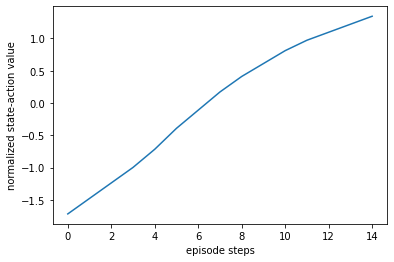

Episode 6, f(w) = -1.25, w = [3.5]
t=0 i=0 action=0
wt_prev=[3.5]
wt_next=[3.5]
f(wt)=-1.250000000000007
rs=[-1.25]
xt_prev=[ 0.51  0.51  0.51 -5.2  -5.2  -5.2 ]
xt_next=[ 0.    0.51  0.51 -5.   -5.2  -5.2 ]
f_hist=[-1.250000000000007, -1.250000000000007, -1.7600000000000078]
g_hist=[array([-5.]), array([-5.]), array([-5.2])]
w_hist=[array([3.5]), array([3.5]), array([3.6])]
t=1 i=0 action=1
wt_prev=[3.5]
wt_next=[3.4]
f(wt)=-0.760000000000006
rs=[-0.76]
xt_prev=[ 0.    0.51  0.51 -5.   -5.2  -5.2 ]
xt_next=[ 0.49  0.49  1.   -5.   -5.   -5.2 ]
f_hist=[-0.760000000000006, -1.250000000000007, -1.250000000000007]
g_hist=[array([-4.8]), array([-5.]), array([-5.])]
w_hist=[array([3.4]), array([3.5]), array([3.5])]
t=2 i=0 action=2
wt_prev=[3.4]
wt_next=[3.5]
f(wt)=-1.250000000000007
rs=[-1.25]
xt_prev=[ 0.49  0.49  1.   -5.   -5.   -5.2 ]
xt_next=[-0.49  0.    0.   -4.8  -5.   -5.  ]
f_hist=[-1.250000000000007, -0.760000000000006, -1.250000000000007]
g_hist=[array([-5.]), array([-4.8]), ar

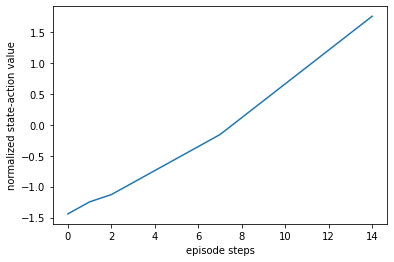

Episode 7, f(w) = -1.76, w = [3.6]
t=0 i=0 action=0
wt_prev=[3.6]
wt_next=[3.6]
f(wt)=-1.7600000000000078
rs=[-1.76]
xt_prev=[ 0.   0.   0.  -5.2 -5.2 -5.2]
xt_next=[ 0.   0.   0.  -5.2 -5.2 -5.2]
f_hist=[-1.7600000000000078, -1.7600000000000078, -1.7600000000000078]
g_hist=[array([-5.2]), array([-5.2]), array([-5.2])]
w_hist=[array([3.6]), array([3.6]), array([3.6])]
t=1 i=0 action=1
wt_prev=[3.6]
wt_next=[3.5]
f(wt)=-1.250000000000007
rs=[-1.25]
xt_prev=[ 0.   0.   0.  -5.2 -5.2 -5.2]
xt_next=[ 0.51  0.51  0.51 -5.2  -5.2  -5.2 ]
f_hist=[-1.250000000000007, -1.7600000000000078, -1.7600000000000078]
g_hist=[array([-5.]), array([-5.2]), array([-5.2])]
w_hist=[array([3.5]), array([3.6]), array([3.6])]
t=2 i=0 action=0
wt_prev=[3.5]
wt_next=[3.5]
f(wt)=-1.250000000000007
rs=[-1.25]
xt_prev=[ 0.51  0.51  0.51 -5.2  -5.2  -5.2 ]
xt_next=[ 0.    0.51  0.51 -5.   -5.2  -5.2 ]
f_hist=[-1.250000000000007, -1.250000000000007, -1.7600000000000078]
g_hist=[array([-5.]), array([-5.]), array([-5.2]

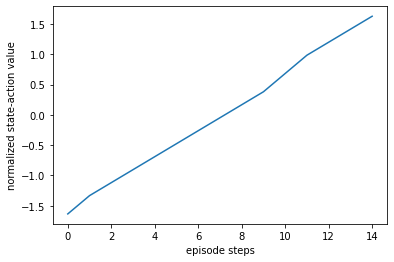

Episode 8, f(w) = -1.25, w = [3.5]
t=0 i=0 action=0
wt_prev=[3.5]
wt_next=[3.5]
f(wt)=-1.250000000000007
rs=[-1.25]
xt_prev=[ 0.  0.  0. -5. -5. -5.]
xt_next=[ 0.  0.  0. -5. -5. -5.]
f_hist=[-1.250000000000007, -1.250000000000007, -1.250000000000007]
g_hist=[array([-5.]), array([-5.]), array([-5.])]
w_hist=[array([3.5]), array([3.5]), array([3.5])]
t=1 i=0 action=2
wt_prev=[3.5]
wt_next=[3.6]
f(wt)=-1.7600000000000078
rs=[-1.76]
xt_prev=[ 0.  0.  0. -5. -5. -5.]
xt_next=[-0.51 -0.51 -0.51 -5.   -5.   -5.  ]
f_hist=[-1.7600000000000078, -1.250000000000007, -1.250000000000007]
g_hist=[array([-5.2]), array([-5.]), array([-5.])]
w_hist=[array([3.6]), array([3.5]), array([3.5])]
t=2 i=0 action=0
wt_prev=[3.6]
wt_next=[3.6]
f(wt)=-1.7600000000000078
rs=[-1.76]
xt_prev=[-0.51 -0.51 -0.51 -5.   -5.   -5.  ]
xt_next=[ 0.   -0.51 -0.51 -5.2  -5.   -5.  ]
f_hist=[-1.7600000000000078, -1.7600000000000078, -1.250000000000007]
g_hist=[array([-5.2]), array([-5.2]), array([-5.])]
w_hist=[array([3.6])

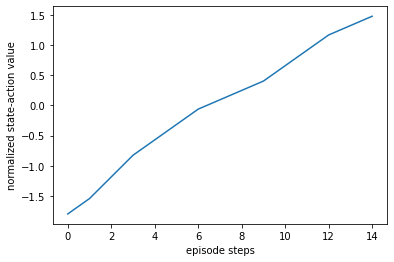

Episode 9, f(w) = -0.29, w = [3.3]
t=0 i=0 action=0
wt_prev=[3.3]
wt_next=[3.3]
f(wt)=-0.29000000000000536
rs=[-0.29]
xt_prev=[ 0.47  0.47  0.96 -4.8  -4.8  -5.  ]
xt_next=[ 0.    0.47  0.47 -4.6  -4.8  -4.8 ]
f_hist=[-0.29000000000000536, -0.29000000000000536, -0.760000000000006]
g_hist=[array([-4.6]), array([-4.6]), array([-4.8])]
w_hist=[array([3.3]), array([3.3]), array([3.4])]
t=1 i=0 action=2
wt_prev=[3.3]
wt_next=[3.4]
f(wt)=-0.760000000000006
rs=[-0.76]
xt_prev=[ 0.    0.47  0.47 -4.6  -4.8  -4.8 ]
xt_next=[-0.47 -0.47  0.   -4.6  -4.6  -4.8 ]
f_hist=[-0.760000000000006, -0.29000000000000536, -0.29000000000000536]
g_hist=[array([-4.8]), array([-4.6]), array([-4.6])]
w_hist=[array([3.4]), array([3.3]), array([3.3])]
t=2 i=0 action=0
wt_prev=[3.4]
wt_next=[3.4]
f(wt)=-0.760000000000006
rs=[-0.76]
xt_prev=[-0.47 -0.47  0.   -4.6  -4.6  -4.8 ]
xt_next=[ 0.   -0.47 -0.47 -4.8  -4.6  -4.6 ]
f_hist=[-0.760000000000006, -0.760000000000006, -0.29000000000000536]
g_hist=[array([-4.8]), a

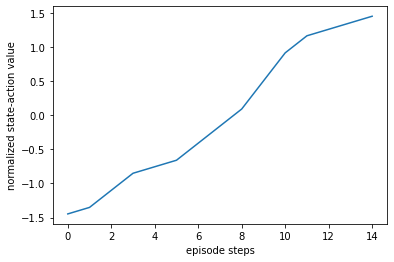

Episode 10, f(w) = 0.16, w = [3.2]


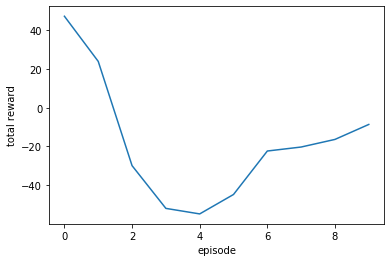

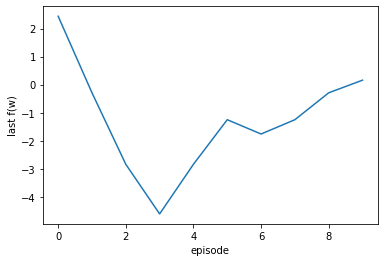

t=0 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[ 0.  0.  0. -2. -2. -2.]
f_hist=[4.0, 4.0, 4.0]
g_hist=[array([-2.]), array([-2.]), array([-2.])]
w_hist=[array([2.]), array([2.]), array([2.])]
t=1 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[ 0.  0.  0. -2. -2. -2.]
f_hist=[4.0, 4.0, 4.0]
g_hist=[array([-2.]), array([-2.]), array([-2.])]
w_hist=[array([2.]), array([2.]), array([2.])]
t=2 i=0 action=2
wt_prev=[2.]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
f_hist=[3.79, 4.0, 4.0]
g_hist=[array([-2.2]), array([-2.]), array([-2.])]
w_hist=[array([2.1]), array([2.]), array([2.])]
t=3 i=0 action=2
wt_prev=[2.1]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
xt_next=[-0.23 -0.44 -0.44 -2.2  -2.   -2.  ]
f_hist=[3.5599999999999996, 3.79, 4.0]
g_hist=[array([-2.4]), 

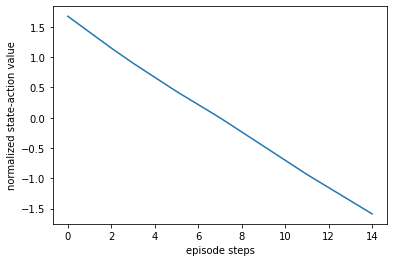

Episode 1, f(w) = 3.31, w = [2.3]
t=0 i=0 action=0
wt_prev=[2.3]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[ 0.   0.   0.  -2.6 -2.6 -2.6]
xt_next=[ 0.   0.   0.  -2.6 -2.6 -2.6]
f_hist=[3.3099999999999996, 3.3099999999999996, 3.3099999999999996]
g_hist=[array([-2.6]), array([-2.6]), array([-2.6])]
w_hist=[array([2.3]), array([2.3]), array([2.3])]
t=1 i=0 action=2
wt_prev=[2.3]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[ 0.   0.   0.  -2.6 -2.6 -2.6]
xt_next=[-0.27 -0.27 -0.27 -2.6  -2.6  -2.6 ]
f_hist=[3.039999999999999, 3.3099999999999996, 3.3099999999999996]
g_hist=[array([-2.8]), array([-2.6]), array([-2.6])]
w_hist=[array([2.4]), array([2.3]), array([2.3])]
t=2 i=0 action=1
wt_prev=[2.4]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[-0.27 -0.27 -0.27 -2.6  -2.6  -2.6 ]
xt_next=[ 0.27  0.    0.   -2.8  -2.6  -2.6 ]
f_hist=[3.3099999999999996, 3.039999999999999, 3.3099999999999996]
g_hist=[array([-2.6]), array([-2.8]), array([-2.6])]
w_hist=[

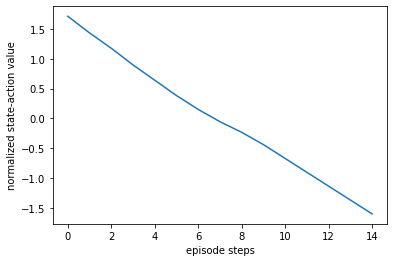

Episode 2, f(w) = 2.75, w = [2.5]
t=0 i=0 action=0
wt_prev=[2.5]
wt_next=[2.5]
f(wt)=2.7499999999999987
rs=[2.75]
xt_prev=[ 0.  0.  0. -3. -3. -3.]
xt_next=[ 0.  0.  0. -3. -3. -3.]
f_hist=[2.7499999999999987, 2.7499999999999987, 2.7499999999999987]
g_hist=[array([-3.]), array([-3.]), array([-3.])]
w_hist=[array([2.5]), array([2.5]), array([2.5])]
t=1 i=0 action=2
wt_prev=[2.5]
wt_next=[2.6]
f(wt)=2.439999999999998
rs=[2.44]
xt_prev=[ 0.  0.  0. -3. -3. -3.]
xt_next=[-0.31 -0.31 -0.31 -3.   -3.   -3.  ]
f_hist=[2.439999999999998, 2.7499999999999987, 2.7499999999999987]
g_hist=[array([-3.2]), array([-3.]), array([-3.])]
w_hist=[array([2.6]), array([2.5]), array([2.5])]
t=2 i=0 action=0
wt_prev=[2.6]
wt_next=[2.6]
f(wt)=2.439999999999998
rs=[2.44]
xt_prev=[-0.31 -0.31 -0.31 -3.   -3.   -3.  ]
xt_next=[ 0.   -0.31 -0.31 -3.2  -3.   -3.  ]
f_hist=[2.439999999999998, 2.439999999999998, 2.7499999999999987]
g_hist=[array([-3.2]), array([-3.2]), array([-3.])]
w_hist=[array([2.6]), array([2.6])

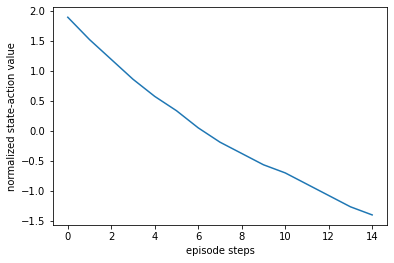

Episode 3, f(w) = 1.00, w = [3.]
t=0 i=0 action=2
wt_prev=[3.]
wt_next=[3.1]
f(wt)=0.5899999999999963
rs=[0.59]
xt_prev=[ 0.   -0.39 -0.39 -4.   -3.8  -3.8 ]
xt_next=[-0.41 -0.41 -0.8  -4.   -4.   -3.8 ]
f_hist=[0.5899999999999963, 0.9999999999999964, 0.9999999999999964]
g_hist=[array([-4.2]), array([-4.]), array([-4.])]
w_hist=[array([3.1]), array([3.]), array([3.])]
t=1 i=0 action=1
wt_prev=[3.1]
wt_next=[3.]
f(wt)=0.9999999999999964
rs=[1.]
xt_prev=[-0.41 -0.41 -0.8  -4.   -4.   -3.8 ]
xt_next=[ 0.41  0.    0.   -4.2  -4.   -4.  ]
f_hist=[0.9999999999999964, 0.5899999999999963, 0.9999999999999964]
g_hist=[array([-4.]), array([-4.2]), array([-4.])]
w_hist=[array([3.]), array([3.1]), array([3.])]
t=2 i=0 action=2
wt_prev=[3.]
wt_next=[3.1]
f(wt)=0.5899999999999963
rs=[0.59]
xt_prev=[ 0.41  0.    0.   -4.2  -4.   -4.  ]
xt_next=[-0.41  0.   -0.41 -4.   -4.2  -4.  ]
f_hist=[0.5899999999999963, 0.9999999999999964, 0.5899999999999963]
g_hist=[array([-4.2]), array([-4.]), array([-4.2])]
w_

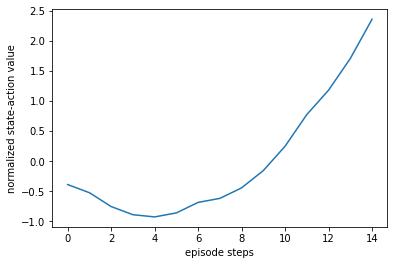

Episode 4, f(w) = -2.29, w = [3.7]
t=0 i=0 action=0
wt_prev=[3.7]
wt_next=[3.7]
f(wt)=-2.290000000000008
rs=[-2.29]
xt_prev=[ 0.55  0.   -0.53 -5.6  -5.4  -5.2 ]
xt_next=[ 0.    0.55  0.   -5.4  -5.6  -5.4 ]
f_hist=[-2.290000000000008, -2.290000000000008, -2.8400000000000087]
g_hist=[array([-5.4]), array([-5.4]), array([-5.6])]
w_hist=[array([3.7]), array([3.7]), array([3.8])]
t=1 i=0 action=1
wt_prev=[3.7]
wt_next=[3.6]
f(wt)=-1.7600000000000078
rs=[-1.76]
xt_prev=[ 0.    0.55  0.   -5.4  -5.6  -5.4 ]
xt_next=[ 0.53  0.53  1.08 -5.4  -5.4  -5.6 ]
f_hist=[-1.7600000000000078, -2.290000000000008, -2.290000000000008]
g_hist=[array([-5.2]), array([-5.4]), array([-5.4])]
w_hist=[array([3.6]), array([3.7]), array([3.7])]
t=2 i=0 action=2
wt_prev=[3.6]
wt_next=[3.7]
f(wt)=-2.290000000000008
rs=[-2.29]
xt_prev=[ 0.53  0.53  1.08 -5.4  -5.4  -5.6 ]
xt_next=[-0.53  0.    0.   -5.2  -5.4  -5.4 ]
f_hist=[-2.290000000000008, -1.7600000000000078, -2.290000000000008]
g_hist=[array([-5.4]), array([-5

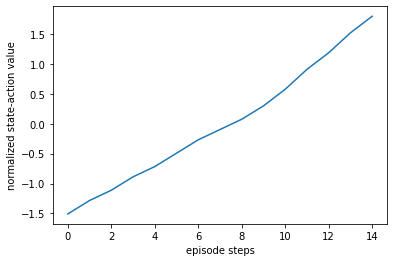

Episode 5, f(w) = -3.41, w = [3.9]
t=0 i=0 action=1
wt_prev=[3.9]
wt_next=[3.8]
f(wt)=-2.8400000000000087
rs=[-2.84]
xt_prev=[-0.57  0.   -0.57 -5.6  -5.8  -5.6 ]
xt_next=[ 0.57  0.    0.57 -5.8  -5.6  -5.8 ]
f_hist=[-2.8400000000000087, -3.410000000000009, -2.8400000000000087]
g_hist=[array([-5.6]), array([-5.8]), array([-5.6])]
w_hist=[array([3.8]), array([3.9]), array([3.8])]
t=1 i=0 action=1
wt_prev=[3.8]
wt_next=[3.7]
f(wt)=-2.290000000000008
rs=[-2.29]
xt_prev=[ 0.57  0.    0.57 -5.8  -5.6  -5.8 ]
xt_next=[ 0.55  1.12  0.55 -5.6  -5.8  -5.6 ]
f_hist=[-2.290000000000008, -2.8400000000000087, -3.410000000000009]
g_hist=[array([-5.4]), array([-5.6]), array([-5.8])]
w_hist=[array([3.7]), array([3.8]), array([3.9])]
t=2 i=0 action=0
wt_prev=[3.7]
wt_next=[3.7]
f(wt)=-2.290000000000008
rs=[-2.29]
xt_prev=[ 0.55  1.12  0.55 -5.6  -5.8  -5.6 ]
xt_next=[ 0.    0.55  1.12 -5.4  -5.6  -5.8 ]
f_hist=[-2.290000000000008, -2.290000000000008, -2.8400000000000087]
g_hist=[array([-5.4]), array([-

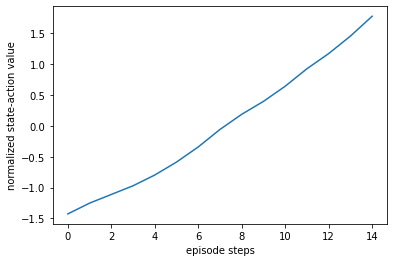

Episode 6, f(w) = -5.89, w = [4.3]
t=0 i=0 action=1
wt_prev=[4.3]
wt_next=[4.2]
f(wt)=-5.240000000000007
rs=[-5.24]
xt_prev=[-0.65 -1.28 -1.89 -6.4  -6.2  -6.  ]
xt_next=[ 0.65  0.   -0.63 -6.6  -6.4  -6.2 ]
f_hist=[-5.240000000000007, -5.890000000000004, -5.240000000000007]
g_hist=[array([-6.4]), array([-6.6]), array([-6.4])]
w_hist=[array([4.2]), array([4.3]), array([4.2])]
t=1 i=0 action=2
wt_prev=[4.2]
wt_next=[4.3]
f(wt)=-5.890000000000004
rs=[-5.89]
xt_prev=[ 0.65  0.   -0.63 -6.6  -6.4  -6.2 ]
xt_next=[-0.65  0.   -0.65 -6.4  -6.6  -6.4 ]
f_hist=[-5.890000000000004, -5.240000000000007, -5.890000000000004]
g_hist=[array([-6.6]), array([-6.4]), array([-6.6])]
w_hist=[array([4.3]), array([4.2]), array([4.3])]
t=2 i=0 action=1
wt_prev=[4.3]
wt_next=[4.2]
f(wt)=-5.240000000000007
rs=[-5.24]
xt_prev=[-0.65  0.   -0.65 -6.4  -6.6  -6.4 ]
xt_next=[ 0.65  0.    0.65 -6.6  -6.4  -6.6 ]
f_hist=[-5.240000000000007, -5.890000000000004, -5.240000000000007]
g_hist=[array([-6.4]), array([-6.6])

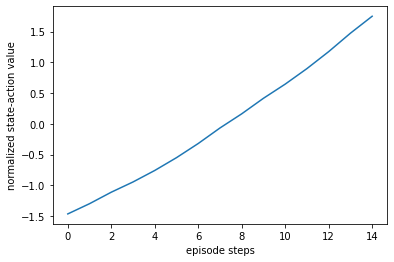

Episode 7, f(w) = -9.44, w = [4.8]
t=0 i=0 action=2
wt_prev=[4.8]
wt_next=[4.9]
f(wt)=-10.209999999999988
rs=[-10.21]
xt_prev=[-0.75  0.   -0.75 -7.4  -7.6  -7.4 ]
xt_next=[-0.77 -1.52 -0.77 -7.6  -7.4  -7.6 ]
f_hist=[-10.209999999999988, -9.439999999999992, -8.689999999999994]
g_hist=[array([-7.8]), array([-7.6]), array([-7.4])]
w_hist=[array([4.9]), array([4.8]), array([4.7])]
t=1 i=0 action=2
wt_prev=[4.9]
wt_next=[5.]
f(wt)=-10.999999999999986
rs=[-11.]
xt_prev=[-0.77 -1.52 -0.77 -7.6  -7.4  -7.6 ]
xt_next=[-0.79 -1.56 -2.31 -7.8  -7.6  -7.4 ]
f_hist=[-10.999999999999986, -10.209999999999988, -9.439999999999992]
g_hist=[array([-8.]), array([-7.8]), array([-7.6])]
w_hist=[array([5.]), array([4.9]), array([4.8])]
t=2 i=0 action=2
wt_prev=[5.]
wt_next=[5.1]
f(wt)=-11.809999999999981
rs=[-11.81]
xt_prev=[-0.79 -1.56 -2.31 -7.8  -7.6  -7.4 ]
xt_next=[-0.81 -1.6  -2.37 -8.   -7.8  -7.6 ]
f_hist=[-11.809999999999981, -10.999999999999986, -10.209999999999988]
g_hist=[array([-8.2]), array([

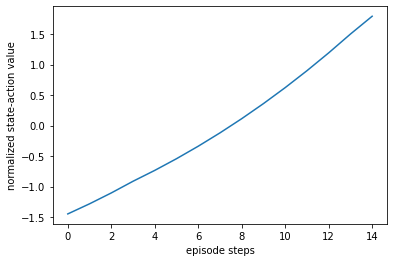

Episode 8, f(w) = -19.01, w = [5.9]
t=0 i=0 action=1
wt_prev=[5.9]
wt_next=[5.8]
f(wt)=-18.039999999999957
rs=[-18.04]
xt_prev=[-0.97  0.   -0.97 -9.6  -9.8  -9.6 ]
xt_next=[ 0.97  0.    0.97 -9.8  -9.6  -9.8 ]
f_hist=[-18.039999999999957, -19.009999999999952, -18.039999999999957]
g_hist=[array([-9.6]), array([-9.8]), array([-9.6])]
w_hist=[array([5.8]), array([5.9]), array([5.8])]
t=1 i=0 action=1
wt_prev=[5.8]
wt_next=[5.7]
f(wt)=-17.08999999999996
rs=[-17.09]
xt_prev=[ 0.97  0.    0.97 -9.8  -9.6  -9.8 ]
xt_next=[ 0.95  1.92  0.95 -9.6  -9.8  -9.6 ]
f_hist=[-17.08999999999996, -18.039999999999957, -19.009999999999952]
g_hist=[array([-9.4]), array([-9.6]), array([-9.8])]
w_hist=[array([5.7]), array([5.8]), array([5.9])]
t=2 i=0 action=2
wt_prev=[5.7]
wt_next=[5.8]
f(wt)=-18.039999999999957
rs=[-18.04]
xt_prev=[ 0.95  1.92  0.95 -9.6  -9.8  -9.6 ]
xt_next=[-0.95  0.    0.97 -9.4  -9.6  -9.8 ]
f_hist=[-18.039999999999957, -17.08999999999996, -18.039999999999957]
g_hist=[array([-9.6]), 

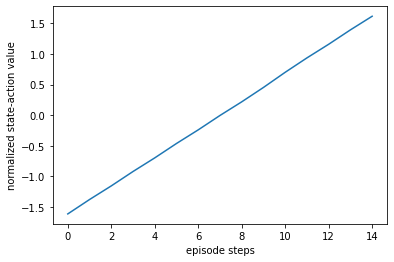

Episode 9, f(w) = -18.04, w = [5.8]
t=0 i=0 action=2
wt_prev=[5.8]
wt_next=[5.9]
f(wt)=-19.009999999999952
rs=[-19.01]
xt_prev=[-0.95  0.   -0.95 -9.4  -9.6  -9.4 ]
xt_next=[-0.97 -1.92 -0.97 -9.6  -9.4  -9.6 ]
f_hist=[-19.009999999999952, -18.039999999999957, -17.08999999999996]
g_hist=[array([-9.8]), array([-9.6]), array([-9.4])]
w_hist=[array([5.9]), array([5.8]), array([5.7])]
t=1 i=0 action=2
wt_prev=[5.9]
wt_next=[6.]
f(wt)=-19.999999999999947
rs=[-20.]
xt_prev=[-0.97 -1.92 -0.97 -9.6  -9.4  -9.6 ]
xt_next=[-0.99 -1.96 -2.91 -9.8  -9.6  -9.4 ]
f_hist=[-19.999999999999947, -19.009999999999952, -18.039999999999957]
g_hist=[array([-10.]), array([-9.8]), array([-9.6])]
w_hist=[array([6.]), array([5.9]), array([5.8])]
t=2 i=0 action=0
wt_prev=[6.]
wt_next=[6.]
f(wt)=-19.999999999999947
rs=[-20.]
xt_prev=[-0.99 -1.96 -2.91 -9.8  -9.6  -9.4 ]
xt_next=[  0.    -0.99  -1.96 -10.    -9.8   -9.6 ]
f_hist=[-19.999999999999947, -19.999999999999947, -19.009999999999952]
g_hist=[array([-10.]), 

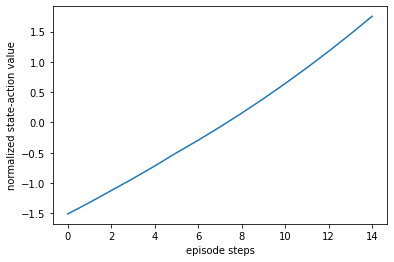

Episode 10, f(w) = -31.00, w = [7.]


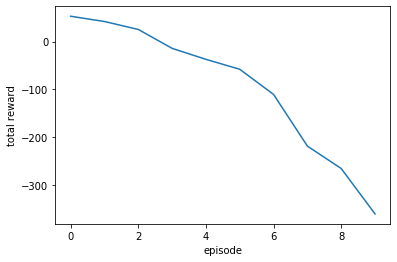

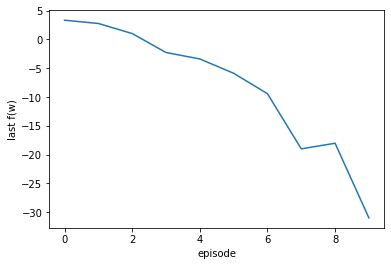

t=0 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[ 0.  0.  0. -2. -2. -2.]
f_hist=[4.0, 4.0, 4.0]
g_hist=[array([-2.]), array([-2.]), array([-2.])]
w_hist=[array([2.]), array([2.]), array([2.])]
t=1 i=0 action=2
wt_prev=[2.]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
f_hist=[3.79, 4.0, 4.0]
g_hist=[array([-2.2]), array([-2.]), array([-2.])]
w_hist=[array([2.1]), array([2.]), array([2.1])]
t=2 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
xt_next=[ 0.   -0.21 -0.21 -2.2  -2.   -2.  ]
f_hist=[3.79, 3.79, 4.0]
g_hist=[array([-2.2]), array([-2.2]), array([-2.])]
w_hist=[array([2.1]), array([2.1]), array([2.])]
t=3 i=0 action=2
wt_prev=[2.1]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[ 0.   -0.21 -0.21 -2.2  -2.   -2.  ]
xt_next=[-0.23 -0.23 -0.44 -2.2  -2.2  -2.  ]
f_hist=[3.5599999999999996

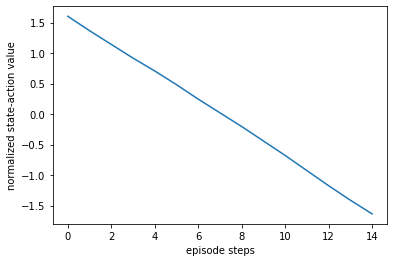

Episode 1, f(w) = 3.56, w = [2.2]
t=0 i=0 action=0
wt_prev=[2.2]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.23 -0.44 -0.63 -2.2  -2.   -1.8 ]
xt_next=[ 0.   -0.23 -0.44 -2.4  -2.2  -2.  ]
f_hist=[3.5599999999999996, 3.5599999999999996, 3.79]
g_hist=[array([-2.4]), array([-2.4]), array([-2.2])]
w_hist=[array([2.2]), array([2.2]), array([2.1])]
t=1 i=0 action=1
wt_prev=[2.2]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.   -0.23 -0.44 -2.4  -2.2  -2.  ]
xt_next=[ 0.23  0.23  0.   -2.4  -2.4  -2.2 ]
f_hist=[3.79, 3.5599999999999996, 3.5599999999999996]
g_hist=[array([-2.2]), array([-2.4]), array([-2.4])]
w_hist=[array([2.1]), array([2.2]), array([2.2])]
t=2 i=0 action=2
wt_prev=[2.1]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[ 0.23  0.23  0.   -2.4  -2.4  -2.2 ]
xt_next=[-0.23  0.    0.   -2.2  -2.4  -2.4 ]
f_hist=[3.5599999999999996, 3.79, 3.5599999999999996]
g_hist=[array([-2.4]), array([-2.2]), array([-2.4])]
w_hist=[array([2.2]), array([2.1]), array([

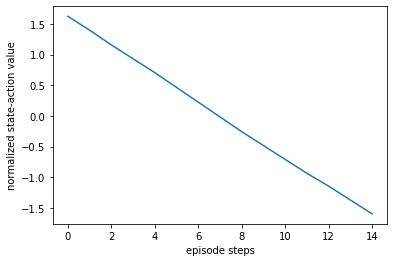

Episode 2, f(w) = 3.56, w = [2.2]
t=0 i=0 action=0
wt_prev=[2.2]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[ 0.    0.    0.25 -2.4  -2.4  -2.6 ]
xt_next=[ 0.   0.   0.  -2.4 -2.4 -2.4]
f_hist=[3.5599999999999996, 3.5599999999999996, 3.5599999999999996]
g_hist=[array([-2.4]), array([-2.4]), array([-2.4])]
w_hist=[array([2.2]), array([2.2]), array([2.2])]
t=1 i=0 action=0
wt_prev=[2.2]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[ 0.   0.   0.  -2.4 -2.4 -2.4]
xt_next=[ 0.   0.   0.  -2.4 -2.4 -2.4]
f_hist=[3.5599999999999996, 3.5599999999999996, 3.5599999999999996]
g_hist=[array([-2.4]), array([-2.4]), array([-2.4])]
w_hist=[array([2.2]), array([2.2]), array([2.2])]
t=2 i=0 action=0
wt_prev=[2.2]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[ 0.   0.   0.  -2.4 -2.4 -2.4]
xt_next=[ 0.   0.   0.  -2.4 -2.4 -2.4]
f_hist=[3.5599999999999996, 3.5599999999999996, 3.5599999999999996]
g_hist=[array([-2.4]), array([-2.4]), array([-2.4])]
w_hist=[array([2.

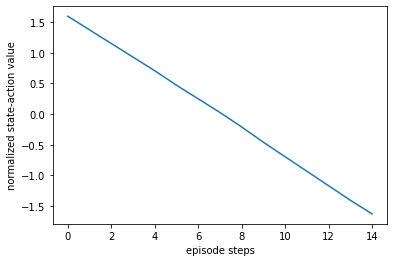

Episode 3, f(w) = 3.56, w = [2.2]
t=0 i=0 action=1
wt_prev=[2.2]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.   -0.23 -0.23 -2.4  -2.2  -2.2 ]
xt_next=[ 0.23  0.23  0.   -2.4  -2.4  -2.2 ]
f_hist=[3.79, 3.5599999999999996, 3.5599999999999996]
g_hist=[array([-2.2]), array([-2.4]), array([-2.4])]
w_hist=[array([2.1]), array([2.2]), array([2.2])]
t=1 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.23  0.23  0.   -2.4  -2.4  -2.2 ]
xt_next=[ 0.    0.23  0.23 -2.2  -2.4  -2.4 ]
f_hist=[3.79, 3.79, 3.5599999999999996]
g_hist=[array([-2.2]), array([-2.2]), array([-2.4])]
w_hist=[array([2.1]), array([2.1]), array([2.2])]
t=2 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.    0.23  0.23 -2.2  -2.4  -2.4 ]
xt_next=[ 0.    0.    0.23 -2.2  -2.2  -2.4 ]
f_hist=[3.79, 3.79, 3.79]
g_hist=[array([-2.2]), array([-2.2]), array([-2.2])]
w_hist=[array([2.1]), array([2.1]), array([2.1])]
t=3 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.7

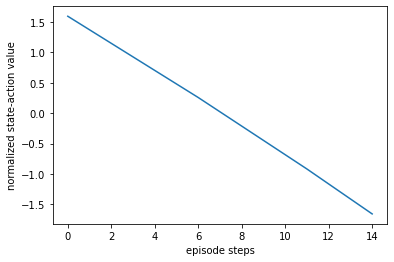

Episode 4, f(w) = 4.36, w = [1.8]
t=0 i=0 action=2
wt_prev=[1.8]
wt_next=[1.9]
f(wt)=4.19
rs=[4.19]
xt_prev=[ 0.17  0.17  0.17 -1.8  -1.8  -1.8 ]
xt_next=[-0.17  0.    0.   -1.6  -1.8  -1.8 ]
f_hist=[4.19, 4.36, 4.19]
g_hist=[array([-1.8]), array([-1.6]), array([-1.8])]
w_hist=[array([1.9]), array([1.8]), array([1.9])]
t=1 i=0 action=1
wt_prev=[1.9]
wt_next=[1.8]
f(wt)=4.36
rs=[4.36]
xt_prev=[-0.17  0.    0.   -1.6  -1.8  -1.8 ]
xt_next=[ 0.17  0.    0.17 -1.8  -1.6  -1.8 ]
f_hist=[4.36, 4.19, 4.36]
g_hist=[array([-1.6]), array([-1.8]), array([-1.6])]
w_hist=[array([1.8]), array([1.9]), array([1.8])]
t=2 i=0 action=1
wt_prev=[1.8]
wt_next=[1.7]
f(wt)=4.510000000000001
rs=[4.51]
xt_prev=[ 0.17  0.    0.17 -1.8  -1.6  -1.8 ]
xt_next=[ 0.15  0.32  0.15 -1.6  -1.8  -1.6 ]
f_hist=[4.510000000000001, 4.36, 4.19]
g_hist=[array([-1.4]), array([-1.6]), array([-1.8])]
w_hist=[array([1.7]), array([1.8]), array([1.9])]
t=3 i=0 action=2
wt_prev=[1.7]
wt_next=[1.8]
f(wt)=4.36
rs=[4.36]
xt_prev=[ 0.1

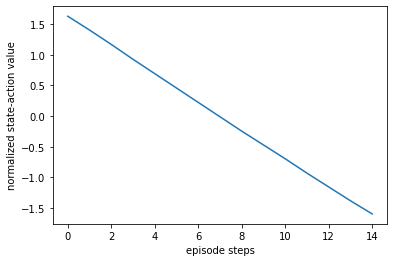

Episode 5, f(w) = 4.00, w = [2.]
t=0 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.   -0.19 -0.19 -2.   -1.8  -1.8 ]
xt_next=[ 0.    0.   -0.19 -2.   -2.   -1.8 ]
f_hist=[4.0, 4.0, 4.0]
g_hist=[array([-2.]), array([-2.]), array([-2.])]
w_hist=[array([2.]), array([2.]), array([2.])]
t=1 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.    0.   -0.19 -2.   -2.   -1.8 ]
xt_next=[ 0.  0.  0. -2. -2. -2.]
f_hist=[4.0, 4.0, 4.0]
g_hist=[array([-2.]), array([-2.]), array([-2.])]
w_hist=[array([2.]), array([2.]), array([2.])]
t=2 i=0 action=1
wt_prev=[2.]
wt_next=[1.9]
f(wt)=4.19
rs=[4.19]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[ 0.19  0.19  0.19 -2.   -2.   -2.  ]
f_hist=[4.19, 4.0, 4.0]
g_hist=[array([-1.8]), array([-2.]), array([-2.])]
w_hist=[array([1.9]), array([2.]), array([2.])]
t=3 i=0 action=0
wt_prev=[1.9]
wt_next=[1.9]
f(wt)=4.19
rs=[4.19]
xt_prev=[ 0.19  0.19  0.19 -2.   -2.   -2.  ]
xt_next=[ 0.    0.19  0.19 -1.8  -2.   -2.  ]
f_hist=

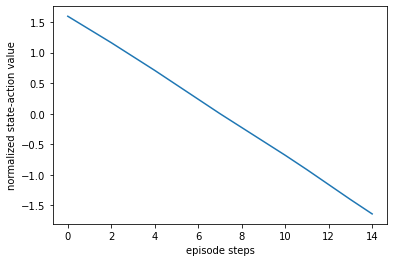

Episode 6, f(w) = 4.19, w = [1.9]
t=0 i=0 action=1
wt_prev=[1.9]
wt_next=[1.8]
f(wt)=4.36
rs=[4.36]
xt_prev=[-0.17 -0.32 -0.32 -1.6  -1.4  -1.4 ]
xt_next=[ 0.17  0.   -0.15 -1.8  -1.6  -1.4 ]
f_hist=[4.36, 4.19, 4.36]
g_hist=[array([-1.6]), array([-1.8]), array([-1.6])]
w_hist=[array([1.8]), array([1.9]), array([1.8])]
t=1 i=0 action=0
wt_prev=[1.8]
wt_next=[1.8]
f(wt)=4.36
rs=[4.36]
xt_prev=[ 0.17  0.   -0.15 -1.8  -1.6  -1.4 ]
xt_next=[ 0.    0.17  0.   -1.6  -1.8  -1.6 ]
f_hist=[4.36, 4.36, 4.19]
g_hist=[array([-1.6]), array([-1.6]), array([-1.8])]
w_hist=[array([1.8]), array([1.8]), array([1.9])]
t=2 i=0 action=1
wt_prev=[1.8]
wt_next=[1.7]
f(wt)=4.510000000000001
rs=[4.51]
xt_prev=[ 0.    0.17  0.   -1.6  -1.8  -1.6 ]
xt_next=[ 0.15  0.15  0.32 -1.6  -1.6  -1.8 ]
f_hist=[4.510000000000001, 4.36, 4.36]
g_hist=[array([-1.4]), array([-1.6]), array([-1.6])]
w_hist=[array([1.7]), array([1.8]), array([1.8])]
t=3 i=0 action=0
wt_prev=[1.7]
wt_next=[1.7]
f(wt)=4.510000000000001
rs=[4.51]


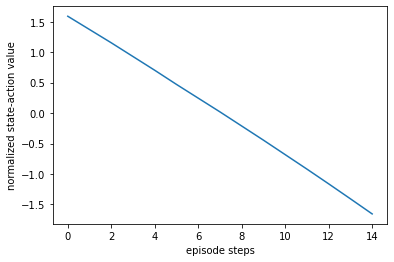

Episode 7, f(w) = 4.99, w = [1.1]
t=0 i=0 action=0
wt_prev=[1.1]
wt_next=[1.1]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.03  0.08  0.15 -0.4  -0.6  -0.8 ]
xt_next=[ 0.    0.03  0.08 -0.2  -0.4  -0.6 ]
f_hist=[4.99, 4.99, 4.96]
g_hist=[array([-0.2]), array([-0.2]), array([-0.4])]
w_hist=[array([1.1]), array([1.1]), array([1.2])]
t=1 i=0 action=0
wt_prev=[1.1]
wt_next=[1.1]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.    0.03  0.08 -0.2  -0.4  -0.6 ]
xt_next=[ 0.    0.    0.03 -0.2  -0.2  -0.4 ]
f_hist=[4.99, 4.99, 4.99]
g_hist=[array([-0.2]), array([-0.2]), array([-0.2])]
w_hist=[array([1.1]), array([1.1]), array([1.1])]
t=2 i=0 action=0
wt_prev=[1.1]
wt_next=[1.1]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.    0.    0.03 -0.2  -0.2  -0.4 ]
xt_next=[ 0.   0.   0.  -0.2 -0.2 -0.2]
f_hist=[4.99, 4.99, 4.99]
g_hist=[array([-0.2]), array([-0.2]), array([-0.2])]
w_hist=[array([1.1]), array([1.1]), array([1.1])]
t=3 i=0 action=0
wt_prev=[1.1]
wt_next=[1.1]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.   0.   0.  -0.2 -0.2 -0.2]
xt_ne

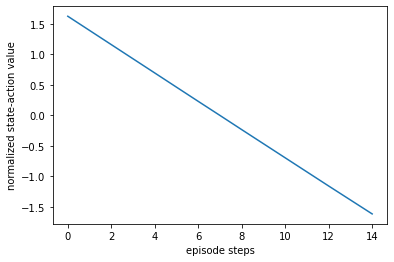

Episode 8, f(w) = 4.84, w = [0.6]
t=0 i=0 action=1
wt_prev=[0.6]
wt_next=[0.5]
f(wt)=4.749999999999999
rs=[4.75]
xt_prev=[-0.07 -0.07 -0.12  0.6   0.6   0.4 ]
xt_next=[-0.09 -0.16 -0.16  0.8   0.6   0.6 ]
f_hist=[4.749999999999999, 4.84, 4.909999999999999]
g_hist=[array([1.]), array([0.8]), array([0.6])]
w_hist=[array([0.5]), array([0.6]), array([0.7])]
t=1 i=0 action=2
wt_prev=[0.5]
wt_next=[0.6]
f(wt)=4.84
rs=[4.84]
xt_prev=[-0.09 -0.16 -0.16  0.8   0.6   0.6 ]
xt_next=[ 0.09  0.   -0.07  1.    0.8   0.6 ]
f_hist=[4.84, 4.749999999999999, 4.84]
g_hist=[array([0.8]), array([1.]), array([0.8])]
w_hist=[array([0.6]), array([0.5]), array([0.6])]
t=2 i=0 action=1
wt_prev=[0.6]
wt_next=[0.5]
f(wt)=4.749999999999999
rs=[4.75]
xt_prev=[ 0.09  0.   -0.07  1.    0.8   0.6 ]
xt_next=[-0.09  0.   -0.09  0.8   1.    0.8 ]
f_hist=[4.749999999999999, 4.84, 4.749999999999999]
g_hist=[array([1.]), array([0.8]), array([1.])]
w_hist=[array([0.5]), array([0.6]), array([0.5])]
t=3 i=0 action=2
wt_prev=[0

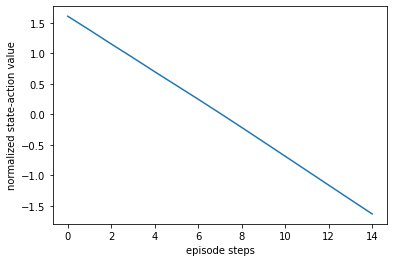

Episode 9, f(w) = 4.99, w = [0.9]
t=0 i=0 action=0
wt_prev=[0.9]
wt_next=[0.9]
f(wt)=4.99
rs=[4.99]
xt_prev=[0.03 0.   0.   0.4  0.2  0.2 ]
xt_next=[0.   0.03 0.   0.2  0.4  0.2 ]
f_hist=[4.99, 4.99, 4.96]
g_hist=[array([0.2]), array([0.2]), array([0.4])]
w_hist=[array([0.9]), array([0.9]), array([0.8])]
t=1 i=0 action=1
wt_prev=[0.9]
wt_next=[0.8]
f(wt)=4.96
rs=[4.96]
xt_prev=[0.   0.03 0.   0.2  0.4  0.2 ]
xt_next=[-0.03 -0.03  0.    0.2   0.2   0.4 ]
f_hist=[4.96, 4.99, 4.99]
g_hist=[array([0.4]), array([0.2]), array([0.2])]
w_hist=[array([0.8]), array([0.9]), array([0.9])]
t=2 i=0 action=0
wt_prev=[0.8]
wt_next=[0.8]
f(wt)=4.96
rs=[4.96]
xt_prev=[-0.03 -0.03  0.    0.2   0.2   0.4 ]
xt_next=[ 0.   -0.03 -0.03  0.4   0.2   0.2 ]
f_hist=[4.96, 4.96, 4.99]
g_hist=[array([0.4]), array([0.4]), array([0.2])]
w_hist=[array([0.8]), array([0.8]), array([0.9])]
t=3 i=0 action=2
wt_prev=[0.8]
wt_next=[0.9]
f(wt)=4.99
rs=[4.99]
xt_prev=[ 0.   -0.03 -0.03  0.4   0.2   0.2 ]
xt_next=[0.03 0.03 0

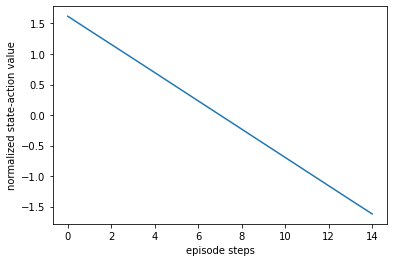

Episode 10, f(w) = 4.99, w = [1.1]


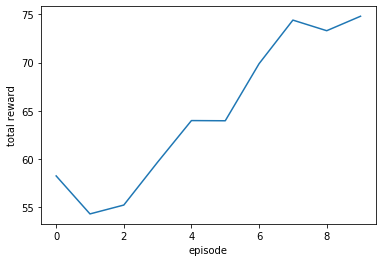

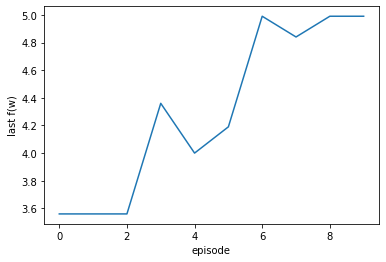

t=0 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[ 0.  0.  0. -2. -2. -2.]
f_hist=[4.0, 4.0, 4.0]
g_hist=[array([-2.]), array([-2.]), array([-2.])]
w_hist=[array([2.]), array([2.]), array([2.])]
t=1 i=0 action=2
wt_prev=[2.]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
f_hist=[3.79, 4.0, 4.0]
g_hist=[array([-2.2]), array([-2.]), array([-2.])]
w_hist=[array([2.1]), array([2.]), array([2.1])]
t=2 i=0 action=2
wt_prev=[2.1]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
xt_next=[-0.23 -0.44 -0.44 -2.2  -2.   -2.  ]
f_hist=[3.5599999999999996, 3.79, 4.0]
g_hist=[array([-2.4]), array([-2.2]), array([-2.])]
w_hist=[array([2.2]), array([2.1]), array([2.])]
t=3 i=0 action=0
wt_prev=[2.2]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.23 -0.44 -0.44 -2.2  -2.   -2.  ]
xt_next=[ 0.   -0.23 -0.44 -2.4  -2.2  -2.  

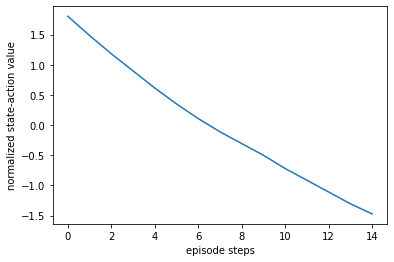

Episode 1, f(w) = 1.76, w = [2.8]
t=0 i=0 action=1
wt_prev=[2.8]
wt_next=[2.7]
f(wt)=2.109999999999998
rs=[2.11]
xt_prev=[-0.35 -0.68 -0.68 -3.4  -3.2  -3.2 ]
xt_next=[ 0.35  0.   -0.33 -3.6  -3.4  -3.2 ]
f_hist=[2.109999999999998, 1.7599999999999976, 2.109999999999998]
g_hist=[array([-3.4]), array([-3.6]), array([-3.4])]
w_hist=[array([2.7]), array([2.8]), array([2.7])]
t=1 i=0 action=0
wt_prev=[2.7]
wt_next=[2.7]
f(wt)=2.109999999999998
rs=[2.11]
xt_prev=[ 0.35  0.   -0.33 -3.6  -3.4  -3.2 ]
xt_next=[ 0.    0.35  0.   -3.4  -3.6  -3.4 ]
f_hist=[2.109999999999998, 2.109999999999998, 1.7599999999999976]
g_hist=[array([-3.4]), array([-3.4]), array([-3.6])]
w_hist=[array([2.7]), array([2.7]), array([2.8])]
t=2 i=0 action=0
wt_prev=[2.7]
wt_next=[2.7]
f(wt)=2.109999999999998
rs=[2.11]
xt_prev=[ 0.    0.35  0.   -3.4  -3.6  -3.4 ]
xt_next=[ 0.    0.    0.35 -3.4  -3.4  -3.6 ]
f_hist=[2.109999999999998, 2.109999999999998, 2.109999999999998]
g_hist=[array([-3.4]), array([-3.4]), array([-3.4]

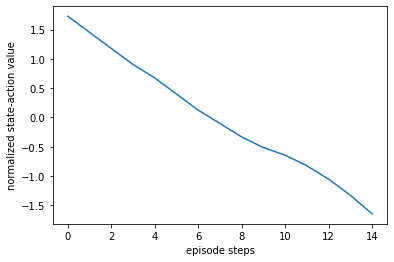

Episode 2, f(w) = 2.11, w = [2.7]
t=0 i=0 action=0
wt_prev=[2.7]
wt_next=[2.7]
f(wt)=2.109999999999998
rs=[2.11]
xt_prev=[-0.33  0.    0.35 -3.2  -3.4  -3.6 ]
xt_next=[ 0.   -0.33  0.   -3.4  -3.2  -3.4 ]
f_hist=[2.109999999999998, 2.109999999999998, 2.439999999999998]
g_hist=[array([-3.4]), array([-3.4]), array([-3.2])]
w_hist=[array([2.7]), array([2.7]), array([2.6])]
t=1 i=0 action=2
wt_prev=[2.7]
wt_next=[2.8]
f(wt)=1.7599999999999976
rs=[1.76]
xt_prev=[ 0.   -0.33  0.   -3.4  -3.2  -3.4 ]
xt_next=[-0.35 -0.35 -0.68 -3.4  -3.4  -3.2 ]
f_hist=[1.7599999999999976, 2.109999999999998, 2.109999999999998]
g_hist=[array([-3.6]), array([-3.4]), array([-3.4])]
w_hist=[array([2.8]), array([2.7]), array([2.7])]
t=2 i=0 action=1
wt_prev=[2.8]
wt_next=[2.7]
f(wt)=2.109999999999998
rs=[2.11]
xt_prev=[-0.35 -0.35 -0.68 -3.4  -3.4  -3.2 ]
xt_next=[ 0.35  0.    0.   -3.6  -3.4  -3.4 ]
f_hist=[2.109999999999998, 1.7599999999999976, 2.109999999999998]
g_hist=[array([-3.4]), array([-3.6]), array([-3.4

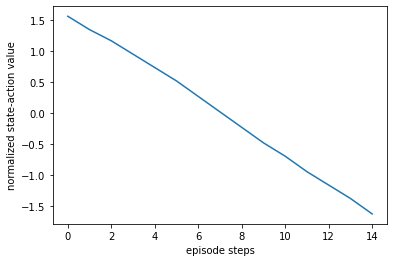

Episode 3, f(w) = 2.75, w = [2.5]
t=0 i=0 action=1
wt_prev=[2.5]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[ 0.31  0.64  0.64 -3.2  -3.4  -3.4 ]
xt_next=[ 0.29  0.6   0.93 -3.   -3.2  -3.4 ]
f_hist=[3.039999999999999, 2.7499999999999987, 2.439999999999998]
g_hist=[array([-2.8]), array([-3.]), array([-3.2])]
w_hist=[array([2.4]), array([2.5]), array([2.6])]
t=1 i=0 action=0
wt_prev=[2.4]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[ 0.29  0.6   0.93 -3.   -3.2  -3.4 ]
xt_next=[ 0.    0.29  0.6  -2.8  -3.   -3.2 ]
f_hist=[3.039999999999999, 3.039999999999999, 2.7499999999999987]
g_hist=[array([-2.8]), array([-2.8]), array([-3.])]
w_hist=[array([2.4]), array([2.4]), array([2.5])]
t=2 i=0 action=1
wt_prev=[2.4]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[ 0.    0.29  0.6  -2.8  -3.   -3.2 ]
xt_next=[ 0.27  0.27  0.56 -2.8  -2.8  -3.  ]
f_hist=[3.3099999999999996, 3.039999999999999, 3.039999999999999]
g_hist=[array([-2.6]), array([-2.8]), array([-2.8]

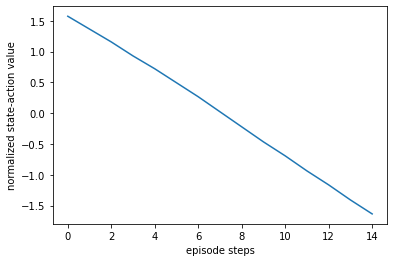

Episode 4, f(w) = 3.04, w = [2.4]
t=0 i=0 action=0
wt_prev=[2.4]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[-0.27 -0.52 -0.27 -2.6  -2.4  -2.6 ]
xt_next=[ 0.   -0.27 -0.52 -2.8  -2.6  -2.4 ]
f_hist=[3.039999999999999, 3.039999999999999, 3.3099999999999996]
g_hist=[array([-2.8]), array([-2.8]), array([-2.6])]
w_hist=[array([2.4]), array([2.4]), array([2.3])]
t=1 i=0 action=0
wt_prev=[2.4]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[ 0.   -0.27 -0.52 -2.8  -2.6  -2.4 ]
xt_next=[ 0.    0.   -0.27 -2.8  -2.8  -2.6 ]
f_hist=[3.039999999999999, 3.039999999999999, 3.039999999999999]
g_hist=[array([-2.8]), array([-2.8]), array([-2.8])]
w_hist=[array([2.4]), array([2.4]), array([2.4])]
t=2 i=0 action=1
wt_prev=[2.4]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[ 0.    0.   -0.27 -2.8  -2.8  -2.6 ]
xt_next=[ 0.27  0.27  0.27 -2.8  -2.8  -2.8 ]
f_hist=[3.3099999999999996, 3.039999999999999, 3.039999999999999]
g_hist=[array([-2.6]), array([-2.8]), array([-2.8

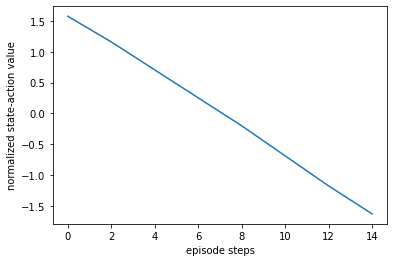

Episode 5, f(w) = 3.31, w = [2.3]
t=0 i=0 action=2
wt_prev=[2.3]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[ 0.    0.   -0.25 -2.6  -2.6  -2.4 ]
xt_next=[-0.27 -0.27 -0.27 -2.6  -2.6  -2.6 ]
f_hist=[3.039999999999999, 3.3099999999999996, 3.3099999999999996]
g_hist=[array([-2.8]), array([-2.6]), array([-2.6])]
w_hist=[array([2.4]), array([2.3]), array([2.3])]
t=1 i=0 action=0
wt_prev=[2.4]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[-0.27 -0.27 -0.27 -2.6  -2.6  -2.6 ]
xt_next=[ 0.   -0.27 -0.27 -2.8  -2.6  -2.6 ]
f_hist=[3.039999999999999, 3.039999999999999, 3.3099999999999996]
g_hist=[array([-2.8]), array([-2.8]), array([-2.6])]
w_hist=[array([2.4]), array([2.4]), array([2.3])]
t=2 i=0 action=0
wt_prev=[2.4]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[ 0.   -0.27 -0.27 -2.8  -2.6  -2.6 ]
xt_next=[ 0.    0.   -0.27 -2.8  -2.8  -2.6 ]
f_hist=[3.039999999999999, 3.039999999999999, 3.039999999999999]
g_hist=[array([-2.8]), array([-2.8]), array([-2.8

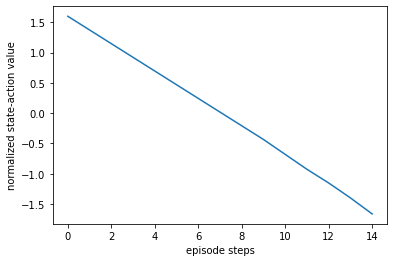

Episode 6, f(w) = 3.79, w = [2.1]
t=0 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.23  0.48  0.75 -2.4  -2.6  -2.8 ]
xt_next=[ 0.    0.23  0.48 -2.2  -2.4  -2.6 ]
f_hist=[3.79, 3.79, 3.5599999999999996]
g_hist=[array([-2.2]), array([-2.2]), array([-2.4])]
w_hist=[array([2.1]), array([2.1]), array([2.2])]
t=1 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.    0.23  0.48 -2.2  -2.4  -2.6 ]
xt_next=[ 0.    0.    0.23 -2.2  -2.2  -2.4 ]
f_hist=[3.79, 3.79, 3.79]
g_hist=[array([-2.2]), array([-2.2]), array([-2.2])]
w_hist=[array([2.1]), array([2.1]), array([2.1])]
t=2 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.    0.    0.23 -2.2  -2.2  -2.4 ]
xt_next=[ 0.   0.   0.  -2.2 -2.2 -2.2]
f_hist=[3.79, 3.79, 3.79]
g_hist=[array([-2.2]), array([-2.2]), array([-2.2])]
w_hist=[array([2.1]), array([2.1]), array([2.1])]
t=3 i=0 action=0
wt_prev=[2.1]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.   0.   0.  -2.2 -2

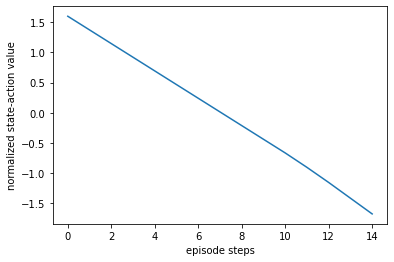

Episode 7, f(w) = 4.36, w = [1.8]
t=0 i=0 action=0
wt_prev=[1.8]
wt_next=[1.8]
f(wt)=4.36
rs=[4.36]
xt_prev=[ 0.    0.    0.17 -1.6  -1.6  -1.8 ]
xt_next=[ 0.   0.   0.  -1.6 -1.6 -1.6]
f_hist=[4.36, 4.36, 4.36]
g_hist=[array([-1.6]), array([-1.6]), array([-1.6])]
w_hist=[array([1.8]), array([1.8]), array([1.8])]
t=1 i=0 action=0
wt_prev=[1.8]
wt_next=[1.8]
f(wt)=4.36
rs=[4.36]
xt_prev=[ 0.   0.   0.  -1.6 -1.6 -1.6]
xt_next=[ 0.   0.   0.  -1.6 -1.6 -1.6]
f_hist=[4.36, 4.36, 4.36]
g_hist=[array([-1.6]), array([-1.6]), array([-1.6])]
w_hist=[array([1.8]), array([1.8]), array([1.8])]
t=2 i=0 action=1
wt_prev=[1.8]
wt_next=[1.7]
f(wt)=4.510000000000001
rs=[4.51]
xt_prev=[ 0.   0.   0.  -1.6 -1.6 -1.6]
xt_next=[ 0.15  0.15  0.15 -1.6  -1.6  -1.6 ]
f_hist=[4.510000000000001, 4.36, 4.36]
g_hist=[array([-1.4]), array([-1.6]), array([-1.6])]
w_hist=[array([1.7]), array([1.8]), array([1.8])]
t=3 i=0 action=0
wt_prev=[1.7]
wt_next=[1.7]
f(wt)=4.510000000000001
rs=[4.51]
xt_prev=[ 0.15  0.15  0.

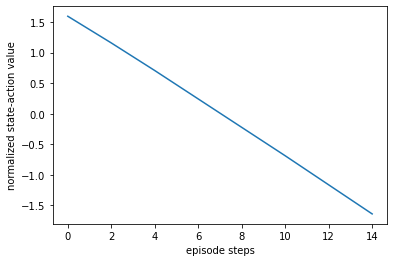

Episode 8, f(w) = 4.75, w = [1.5]
t=0 i=0 action=0
wt_prev=[1.5]
wt_next=[1.5]
f(wt)=4.75
rs=[4.75]
xt_prev=[ 0.  0.  0. -1. -1. -1.]
xt_next=[ 0.  0.  0. -1. -1. -1.]
f_hist=[4.75, 4.75, 4.75]
g_hist=[array([-1.]), array([-1.]), array([-1.])]
w_hist=[array([1.5]), array([1.5]), array([1.5])]
t=1 i=0 action=0
wt_prev=[1.5]
wt_next=[1.5]
f(wt)=4.75
rs=[4.75]
xt_prev=[ 0.  0.  0. -1. -1. -1.]
xt_next=[ 0.  0.  0. -1. -1. -1.]
f_hist=[4.75, 4.75, 4.75]
g_hist=[array([-1.]), array([-1.]), array([-1.])]
w_hist=[array([1.5]), array([1.5]), array([1.5])]
t=2 i=0 action=0
wt_prev=[1.5]
wt_next=[1.5]
f(wt)=4.75
rs=[4.75]
xt_prev=[ 0.  0.  0. -1. -1. -1.]
xt_next=[ 0.  0.  0. -1. -1. -1.]
f_hist=[4.75, 4.75, 4.75]
g_hist=[array([-1.]), array([-1.]), array([-1.])]
w_hist=[array([1.5]), array([1.5]), array([1.5])]
t=3 i=0 action=0
wt_prev=[1.5]
wt_next=[1.5]
f(wt)=4.75
rs=[4.75]
xt_prev=[ 0.  0.  0. -1. -1. -1.]
xt_next=[ 0.  0.  0. -1. -1. -1.]
f_hist=[4.75, 4.75, 4.75]
g_hist=[array([-1.]), arra

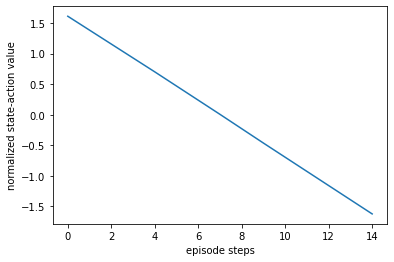

Episode 9, f(w) = 4.75, w = [1.5]
t=0 i=0 action=0
wt_prev=[1.5]
wt_next=[1.5]
f(wt)=4.75
rs=[4.75]
xt_prev=[-0.09 -0.09 -0.09 -0.8  -0.8  -0.8 ]
xt_next=[ 0.   -0.09 -0.09 -1.   -0.8  -0.8 ]
f_hist=[4.75, 4.75, 4.840000000000001]
g_hist=[array([-1.]), array([-1.]), array([-0.8])]
w_hist=[array([1.5]), array([1.5]), array([1.4])]
t=1 i=0 action=1
wt_prev=[1.5]
wt_next=[1.4]
f(wt)=4.840000000000001
rs=[4.84]
xt_prev=[ 0.   -0.09 -0.09 -1.   -0.8  -0.8 ]
xt_next=[ 0.09  0.09  0.   -1.   -1.   -0.8 ]
f_hist=[4.840000000000001, 4.75, 4.75]
g_hist=[array([-0.8]), array([-1.]), array([-1.])]
w_hist=[array([1.4]), array([1.5]), array([1.5])]
t=2 i=0 action=2
wt_prev=[1.4]
wt_next=[1.5]
f(wt)=4.75
rs=[4.75]
xt_prev=[ 0.09  0.09  0.   -1.   -1.   -0.8 ]
xt_next=[-0.09  0.    0.   -0.8  -1.   -1.  ]
f_hist=[4.75, 4.840000000000001, 4.75]
g_hist=[array([-1.]), array([-0.8]), array([-1.])]
w_hist=[array([1.5]), array([1.4]), array([1.5])]
t=3 i=0 action=0
wt_prev=[1.5]
wt_next=[1.5]
f(wt)=4.75
rs=

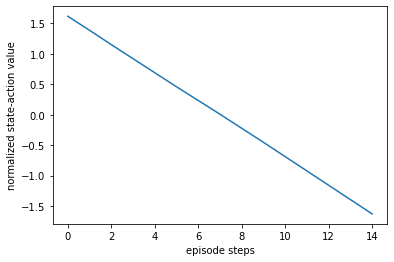

Episode 10, f(w) = 4.91, w = [1.3]


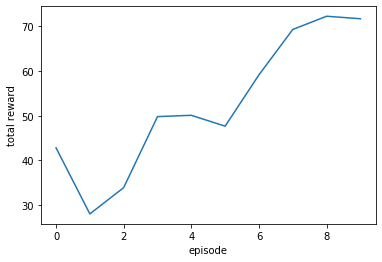

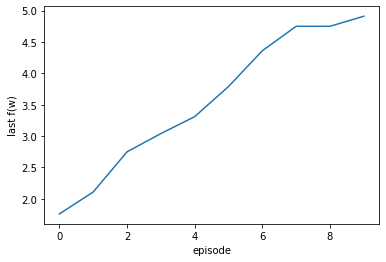

t=0 i=0 action=2
wt_prev=[2.]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
f_hist=[3.79, 4.0, 4.0]
g_hist=[array([-2.2]), array([-2.]), array([-2.])]
w_hist=[array([2.1]), array([2.1]), array([2.1])]
t=1 i=0 action=2
wt_prev=[2.1]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
xt_next=[-0.23 -0.44 -0.44 -2.2  -2.   -2.  ]
f_hist=[3.5599999999999996, 3.79, 4.0]
g_hist=[array([-2.4]), array([-2.2]), array([-2.])]
w_hist=[array([2.2]), array([2.1]), array([2.2])]
t=2 i=0 action=2
wt_prev=[2.2]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[-0.23 -0.44 -0.44 -2.2  -2.   -2.  ]
xt_next=[-0.25 -0.48 -0.69 -2.4  -2.2  -2.  ]
f_hist=[3.3099999999999996, 3.5599999999999996, 3.79]
g_hist=[array([-2.6]), array([-2.4]), array([-2.2])]
w_hist=[array([2.3]), array([2.2]), array([2.1])]
t=3 i=0 action=2
wt_prev=[2.3]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[

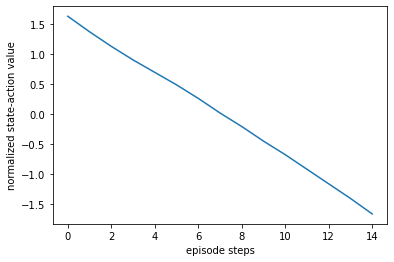

Episode 1, f(w) = 3.79, w = [2.1]
t=0 i=0 action=2
wt_prev=[2.1]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[ 0.    0.23  0.23 -2.2  -2.4  -2.4 ]
xt_next=[-0.23 -0.23  0.   -2.2  -2.2  -2.4 ]
f_hist=[3.5599999999999996, 3.79, 3.79]
g_hist=[array([-2.4]), array([-2.2]), array([-2.2])]
w_hist=[array([2.2]), array([2.1]), array([2.1])]
t=1 i=0 action=2
wt_prev=[2.2]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[-0.23 -0.23  0.   -2.2  -2.2  -2.4 ]
xt_next=[-0.25 -0.48 -0.48 -2.4  -2.2  -2.2 ]
f_hist=[3.3099999999999996, 3.5599999999999996, 3.79]
g_hist=[array([-2.6]), array([-2.4]), array([-2.2])]
w_hist=[array([2.3]), array([2.2]), array([2.1])]
t=2 i=0 action=2
wt_prev=[2.3]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[-0.25 -0.48 -0.48 -2.4  -2.2  -2.2 ]
xt_next=[-0.27 -0.52 -0.75 -2.6  -2.4  -2.2 ]
f_hist=[3.039999999999999, 3.3099999999999996, 3.5599999999999996]
g_hist=[array([-2.8]), array([-2.6]), array([-2.4])]
w_hist=[array([2.4]), array([2.

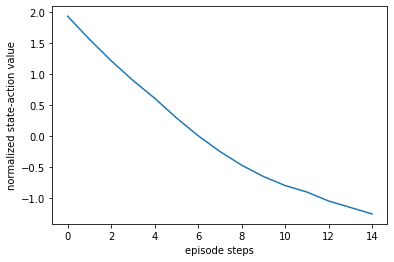

Episode 2, f(w) = 0.59, w = [3.1]
t=0 i=0 action=1
wt_prev=[3.1]
wt_next=[3.]
f(wt)=0.9999999999999964
rs=[1.]
xt_prev=[-0.41 -0.41 -0.8  -4.   -4.   -3.8 ]
xt_next=[ 0.41  0.    0.   -4.2  -4.   -4.  ]
f_hist=[0.9999999999999964, 0.5899999999999963, 0.9999999999999964]
g_hist=[array([-4.]), array([-4.2]), array([-4.])]
w_hist=[array([3.]), array([3.1]), array([3.])]
t=1 i=0 action=2
wt_prev=[3.]
wt_next=[3.1]
f(wt)=0.5899999999999963
rs=[0.59]
xt_prev=[ 0.41  0.    0.   -4.2  -4.   -4.  ]
xt_next=[-0.41  0.   -0.41 -4.   -4.2  -4.  ]
f_hist=[0.5899999999999963, 0.9999999999999964, 0.5899999999999963]
g_hist=[array([-4.2]), array([-4.]), array([-4.2])]
w_hist=[array([3.1]), array([3.]), array([3.1])]
t=2 i=0 action=2
wt_prev=[3.1]
wt_next=[3.2]
f(wt)=0.1599999999999957
rs=[0.16]
xt_prev=[-0.41  0.   -0.41 -4.   -4.2  -4.  ]
xt_next=[-0.43 -0.84 -0.43 -4.2  -4.   -4.2 ]
f_hist=[0.1599999999999957, 0.5899999999999963, 0.9999999999999964]
g_hist=[array([-4.4]), array([-4.2]), array([-4.])

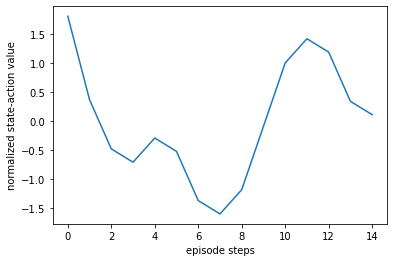

Episode 3, f(w) = -0.29, w = [3.3]
t=0 i=0 action=2
wt_prev=[3.3]
wt_next=[3.4]
f(wt)=-0.760000000000006
rs=[-0.76]
xt_prev=[-0.45 -0.88 -0.45 -4.4  -4.2  -4.4 ]
xt_next=[-0.47 -0.92 -1.35 -4.6  -4.4  -4.2 ]
f_hist=[-0.760000000000006, -0.29000000000000536, 0.1599999999999957]
g_hist=[array([-4.8]), array([-4.6]), array([-4.4])]
w_hist=[array([3.4]), array([3.3]), array([3.2])]
t=1 i=0 action=2
wt_prev=[3.4]
wt_next=[3.5]
f(wt)=-1.250000000000007
rs=[-1.25]
xt_prev=[-0.47 -0.92 -1.35 -4.6  -4.4  -4.2 ]
xt_next=[-0.49 -0.96 -1.41 -4.8  -4.6  -4.4 ]
f_hist=[-1.250000000000007, -0.760000000000006, -0.29000000000000536]
g_hist=[array([-5.]), array([-4.8]), array([-4.6])]
w_hist=[array([3.5]), array([3.4]), array([3.3])]
t=2 i=0 action=2
wt_prev=[3.5]
wt_next=[3.6]
f(wt)=-1.7600000000000078
rs=[-1.76]
xt_prev=[-0.49 -0.96 -1.41 -4.8  -4.6  -4.4 ]
xt_next=[-0.51 -1.   -1.47 -5.   -4.8  -4.6 ]
f_hist=[-1.7600000000000078, -1.250000000000007, -0.760000000000006]
g_hist=[array([-5.2]), array([-

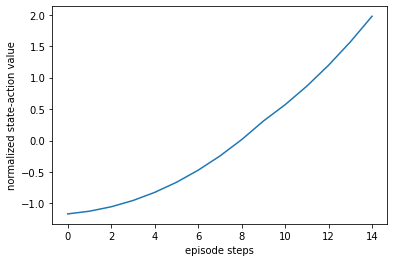

Episode 4, f(w) = -6.56, w = [4.4]
t=0 i=0 action=1
wt_prev=[4.4]
wt_next=[4.3]
f(wt)=-5.890000000000004
rs=[-5.89]
xt_prev=[ 0.69  0.   -0.67 -7.   -6.8  -6.6 ]
xt_next=[ 0.67  1.36  0.67 -6.8  -7.   -6.8 ]
f_hist=[-5.890000000000004, -6.560000000000002, -7.25]
g_hist=[array([-6.6]), array([-6.8]), array([-7.])]
w_hist=[array([4.3]), array([4.4]), array([4.5])]
t=1 i=0 action=2
wt_prev=[4.3]
wt_next=[4.4]
f(wt)=-6.560000000000002
rs=[-6.56]
xt_prev=[ 0.67  1.36  0.67 -6.8  -7.   -6.8 ]
xt_next=[-0.67  0.    0.69 -6.6  -6.8  -7.  ]
f_hist=[-6.560000000000002, -5.890000000000004, -6.560000000000002]
g_hist=[array([-6.8]), array([-6.6]), array([-6.8])]
w_hist=[array([4.4]), array([4.3]), array([4.4])]
t=2 i=0 action=2
wt_prev=[4.4]
wt_next=[4.5]
f(wt)=-7.25
rs=[-7.25]
xt_prev=[-0.67  0.    0.69 -6.6  -6.8  -7.  ]
xt_next=[-0.69 -1.36 -0.69 -6.8  -6.6  -6.8 ]
f_hist=[-7.25, -6.560000000000002, -5.890000000000004]
g_hist=[array([-7.]), array([-6.8]), array([-6.6])]
w_hist=[array([4.5]), ar

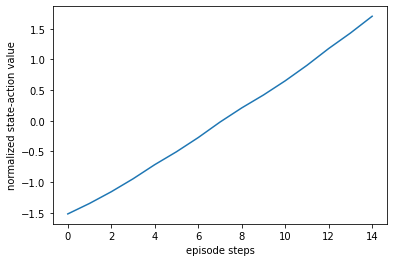

Episode 5, f(w) = -10.21, w = [4.9]
t=0 i=0 action=1
wt_prev=[4.9]
wt_next=[4.8]
f(wt)=-9.439999999999992
rs=[-9.44]
xt_prev=[-0.77 -1.52 -0.77 -7.6  -7.4  -7.6 ]
xt_next=[ 0.77  0.   -0.75 -7.8  -7.6  -7.4 ]
f_hist=[-9.439999999999992, -10.209999999999988, -9.439999999999992]
g_hist=[array([-7.6]), array([-7.8]), array([-7.6])]
w_hist=[array([4.8]), array([4.9]), array([4.8])]
t=1 i=0 action=1
wt_prev=[4.8]
wt_next=[4.7]
f(wt)=-8.689999999999994
rs=[-8.69]
xt_prev=[ 0.77  0.   -0.75 -7.8  -7.6  -7.4 ]
xt_next=[ 0.75  1.52  0.75 -7.6  -7.8  -7.6 ]
f_hist=[-8.689999999999994, -9.439999999999992, -10.209999999999988]
g_hist=[array([-7.4]), array([-7.6]), array([-7.8])]
w_hist=[array([4.7]), array([4.8]), array([4.9])]
t=2 i=0 action=1
wt_prev=[4.7]
wt_next=[4.6]
f(wt)=-7.959999999999997
rs=[-7.96]
xt_prev=[ 0.75  1.52  0.75 -7.6  -7.8  -7.6 ]
xt_next=[ 0.73  1.48  2.25 -7.4  -7.6  -7.8 ]
f_hist=[-7.959999999999997, -8.689999999999994, -9.439999999999992]
g_hist=[array([-7.2]), array([-7.

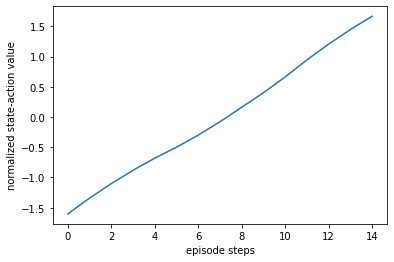

Episode 6, f(w) = -8.69, w = [4.7]
t=0 i=0 action=2
wt_prev=[4.7]
wt_next=[4.8]
f(wt)=-9.439999999999992
rs=[-9.44]
xt_prev=[-0.73  0.    0.75 -7.2  -7.4  -7.6 ]
xt_next=[-0.75 -1.48 -0.75 -7.4  -7.2  -7.4 ]
f_hist=[-9.439999999999992, -8.689999999999994, -7.959999999999997]
g_hist=[array([-7.6]), array([-7.4]), array([-7.2])]
w_hist=[array([4.8]), array([4.7]), array([4.6])]
t=1 i=0 action=2
wt_prev=[4.8]
wt_next=[4.9]
f(wt)=-10.209999999999988
rs=[-10.21]
xt_prev=[-0.75 -1.48 -0.75 -7.4  -7.2  -7.4 ]
xt_next=[-0.77 -1.52 -2.25 -7.6  -7.4  -7.2 ]
f_hist=[-10.209999999999988, -9.439999999999992, -8.689999999999994]
g_hist=[array([-7.8]), array([-7.6]), array([-7.4])]
w_hist=[array([4.9]), array([4.8]), array([4.7])]
t=2 i=0 action=1
wt_prev=[4.9]
wt_next=[4.8]
f(wt)=-9.439999999999992
rs=[-9.44]
xt_prev=[-0.77 -1.52 -2.25 -7.6  -7.4  -7.2 ]
xt_next=[ 0.77  0.   -0.75 -7.8  -7.6  -7.4 ]
f_hist=[-9.439999999999992, -10.209999999999988, -9.439999999999992]
g_hist=[array([-7.6]), array([-7

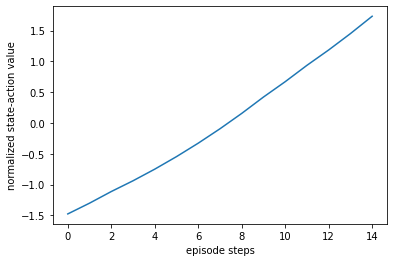

Episode 7, f(w) = -14.36, w = [5.4]
t=0 i=0 action=1
wt_prev=[5.4]
wt_next=[5.3]
f(wt)=-13.489999999999977
rs=[-13.49]
xt_prev=[ 0.89  0.   -0.87 -9.   -8.8  -8.6 ]
xt_next=[ 0.87  1.76  0.87 -8.8  -9.   -8.8 ]
f_hist=[-13.489999999999977, -14.359999999999971, -15.249999999999968]
g_hist=[array([-8.6]), array([-8.8]), array([-9.])]
w_hist=[array([5.3]), array([5.4]), array([5.5])]
t=1 i=0 action=2
wt_prev=[5.3]
wt_next=[5.4]
f(wt)=-14.359999999999971
rs=[-14.36]
xt_prev=[ 0.87  1.76  0.87 -8.8  -9.   -8.8 ]
xt_next=[-0.87  0.    0.89 -8.6  -8.8  -9.  ]
f_hist=[-14.359999999999971, -13.489999999999977, -14.359999999999971]
g_hist=[array([-8.8]), array([-8.6]), array([-8.8])]
w_hist=[array([5.4]), array([5.3]), array([5.4])]
t=2 i=0 action=2
wt_prev=[5.4]
wt_next=[5.5]
f(wt)=-15.249999999999968
rs=[-15.25]
xt_prev=[-0.87  0.    0.89 -8.6  -8.8  -9.  ]
xt_next=[-0.89 -1.76 -0.89 -8.8  -8.6  -8.8 ]
f_hist=[-15.249999999999968, -14.359999999999971, -13.489999999999977]
g_hist=[array([-9.]),

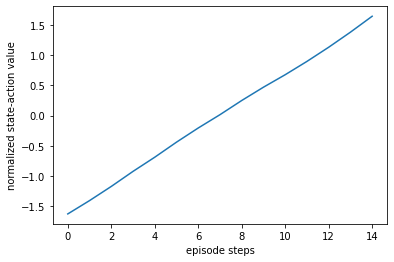

Episode 8, f(w) = -17.09, w = [5.7]
t=0 i=0 action=2
wt_prev=[5.7]
wt_next=[5.8]
f(wt)=-18.039999999999957
rs=[-18.04]
xt_prev=[-0.93 -1.84 -2.73 -9.2  -9.   -8.8 ]
xt_next=[-0.95 -1.88 -2.79 -9.4  -9.2  -9.  ]
f_hist=[-18.039999999999957, -17.08999999999996, -16.159999999999965]
g_hist=[array([-9.6]), array([-9.4]), array([-9.2])]
w_hist=[array([5.8]), array([5.7]), array([5.6])]
t=1 i=0 action=2
wt_prev=[5.8]
wt_next=[5.9]
f(wt)=-19.009999999999952
rs=[-19.01]
xt_prev=[-0.95 -1.88 -2.79 -9.4  -9.2  -9.  ]
xt_next=[-0.97 -1.92 -2.85 -9.6  -9.4  -9.2 ]
f_hist=[-19.009999999999952, -18.039999999999957, -17.08999999999996]
g_hist=[array([-9.8]), array([-9.6]), array([-9.4])]
w_hist=[array([5.9]), array([5.8]), array([5.7])]
t=2 i=0 action=2
wt_prev=[5.9]
wt_next=[6.]
f(wt)=-19.999999999999947
rs=[-20.]
xt_prev=[-0.97 -1.92 -2.85 -9.6  -9.4  -9.2 ]
xt_next=[-0.99 -1.96 -2.91 -9.8  -9.6  -9.4 ]
f_hist=[-19.999999999999947, -19.009999999999952, -18.039999999999957]
g_hist=[array([-10.]), ar

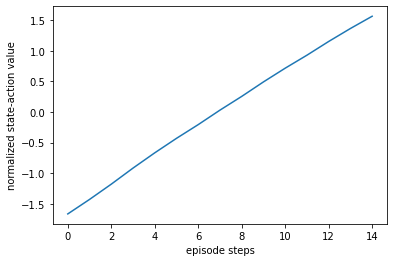

Episode 9, f(w) = -16.16, w = [5.6]
t=0 i=0 action=1
wt_prev=[5.6]
wt_next=[5.5]
f(wt)=-15.249999999999968
rs=[-15.25]
xt_prev=[-0.91  0.    0.93 -9.   -9.2  -9.4 ]
xt_next=[ 0.91  0.    0.91 -9.2  -9.   -9.2 ]
f_hist=[-15.249999999999968, -16.159999999999965, -15.249999999999968]
g_hist=[array([-9.]), array([-9.2]), array([-9.])]
w_hist=[array([5.5]), array([5.6]), array([5.5])]
t=1 i=0 action=2
wt_prev=[5.5]
wt_next=[5.6]
f(wt)=-16.159999999999965
rs=[-16.16]
xt_prev=[ 0.91  0.    0.91 -9.2  -9.   -9.2 ]
xt_next=[-0.91  0.   -0.91 -9.   -9.2  -9.  ]
f_hist=[-16.159999999999965, -15.249999999999968, -16.159999999999965]
g_hist=[array([-9.2]), array([-9.]), array([-9.2])]
w_hist=[array([5.6]), array([5.5]), array([5.6])]
t=2 i=0 action=2
wt_prev=[5.6]
wt_next=[5.7]
f(wt)=-17.08999999999996
rs=[-17.09]
xt_prev=[-0.91  0.   -0.91 -9.   -9.2  -9.  ]
xt_next=[-0.93 -1.84 -0.93 -9.2  -9.   -9.2 ]
f_hist=[-17.08999999999996, -16.159999999999965, -15.249999999999968]
g_hist=[array([-9.4]), ar

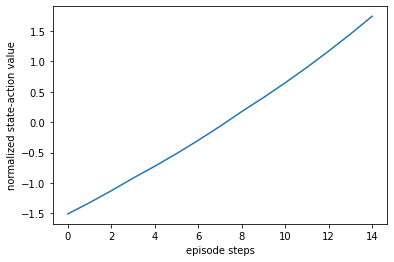

Episode 10, f(w) = -25.25, w = [6.5]


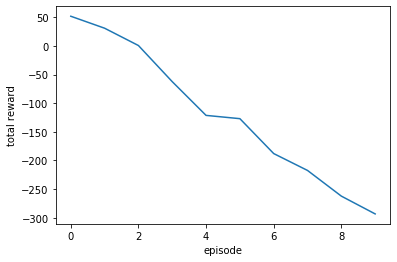

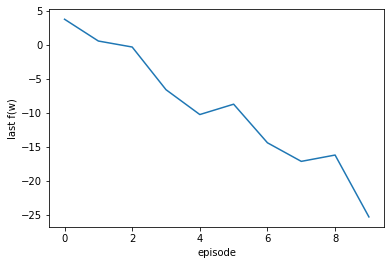

t=0 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[ 0.  0.  0. -2. -2. -2.]
f_hist=[4.0, 4.0, 4.0]
g_hist=[array([-2.]), array([-2.]), array([-2.])]
w_hist=[array([2.]), array([2.]), array([2.])]
t=1 i=0 action=2
wt_prev=[2.]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.  0.  0. -2. -2. -2.]
xt_next=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
f_hist=[3.79, 4.0, 4.0]
g_hist=[array([-2.2]), array([-2.]), array([-2.])]
w_hist=[array([2.1]), array([2.]), array([2.1])]
t=2 i=0 action=1
wt_prev=[2.1]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[-0.21 -0.21 -0.21 -2.   -2.   -2.  ]
xt_next=[ 0.21  0.    0.   -2.2  -2.   -2.  ]
f_hist=[4.0, 3.79, 4.0]
g_hist=[array([-2.]), array([-2.2]), array([-2.])]
w_hist=[array([2.]), array([2.1]), array([2.])]
t=3 i=0 action=0
wt_prev=[2.]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.21  0.    0.   -2.2  -2.   -2.  ]
xt_next=[ 0.    0.21  0.   -2.   -2.2  -2.  ]
f_hist=[4.0, 4.0, 3.79]
g_hist=[array([-2.]), array(

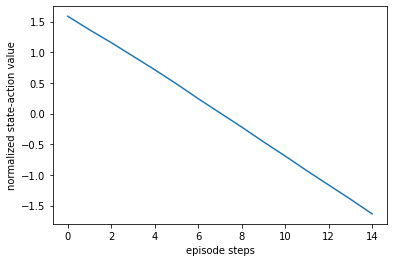

Episode 1, f(w) = 4.19, w = [1.9]
t=0 i=0 action=2
wt_prev=[1.9]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[-0.17  0.    0.   -1.6  -1.8  -1.8 ]
xt_next=[-0.19 -0.36 -0.19 -1.8  -1.6  -1.8 ]
f_hist=[4.0, 4.19, 4.36]
g_hist=[array([-2.]), array([-1.8]), array([-1.6])]
w_hist=[array([2.]), array([1.9]), array([1.8])]
t=1 i=0 action=1
wt_prev=[2.]
wt_next=[1.9]
f(wt)=4.19
rs=[4.19]
xt_prev=[-0.19 -0.36 -0.19 -1.8  -1.6  -1.8 ]
xt_next=[ 0.19  0.   -0.17 -2.   -1.8  -1.6 ]
f_hist=[4.19, 4.0, 4.19]
g_hist=[array([-1.8]), array([-2.]), array([-1.8])]
w_hist=[array([1.9]), array([2.]), array([1.9])]
t=2 i=0 action=2
wt_prev=[1.9]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.19  0.   -0.17 -2.   -1.8  -1.6 ]
xt_next=[-0.19  0.   -0.19 -1.8  -2.   -1.8 ]
f_hist=[4.0, 4.19, 4.0]
g_hist=[array([-2.]), array([-1.8]), array([-2.])]
w_hist=[array([2.]), array([1.9]), array([2.])]
t=3 i=0 action=2
wt_prev=[2.]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[-0.19  0.   -0.19 -1.8  -2.   -1.8 ]
xt_next=[-0.21 

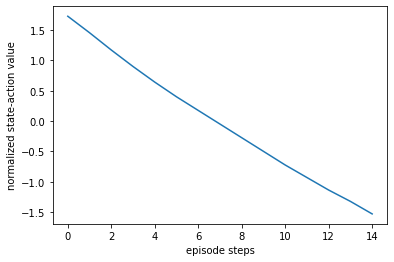

Episode 2, f(w) = 3.31, w = [2.3]
t=0 i=0 action=1
wt_prev=[2.3]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[ 0.27  0.56  0.27 -2.8  -3.   -2.8 ]
xt_next=[ 0.25  0.52  0.81 -2.6  -2.8  -3.  ]
f_hist=[3.5599999999999996, 3.3099999999999996, 3.039999999999999]
g_hist=[array([-2.4]), array([-2.6]), array([-2.8])]
w_hist=[array([2.2]), array([2.3]), array([2.4])]
t=1 i=0 action=1
wt_prev=[2.2]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.25  0.52  0.81 -2.6  -2.8  -3.  ]
xt_next=[ 0.23  0.48  0.75 -2.4  -2.6  -2.8 ]
f_hist=[3.79, 3.5599999999999996, 3.3099999999999996]
g_hist=[array([-2.2]), array([-2.4]), array([-2.6])]
w_hist=[array([2.1]), array([2.2]), array([2.3])]
t=2 i=0 action=1
wt_prev=[2.1]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.23  0.48  0.75 -2.4  -2.6  -2.8 ]
xt_next=[ 0.21  0.44  0.69 -2.2  -2.4  -2.6 ]
f_hist=[4.0, 3.79, 3.5599999999999996]
g_hist=[array([-2.]), array([-2.2]), array([-2.4])]
w_hist=[array([2.]), array([2.1]), array([2.2])]
t=3 i=0 action=

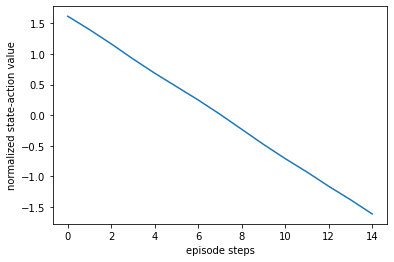

Episode 3, f(w) = 4.00, w = [2.]
t=0 i=0 action=2
wt_prev=[2.]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[ 0.21  0.44  0.21 -2.2  -2.4  -2.2 ]
xt_next=[-0.21  0.    0.23 -2.   -2.2  -2.4 ]
f_hist=[3.79, 4.0, 3.79]
g_hist=[array([-2.2]), array([-2.]), array([-2.2])]
w_hist=[array([2.1]), array([2.]), array([2.1])]
t=1 i=0 action=2
wt_prev=[2.1]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.21  0.    0.23 -2.   -2.2  -2.4 ]
xt_next=[-0.23 -0.44 -0.23 -2.2  -2.   -2.2 ]
f_hist=[3.5599999999999996, 3.79, 4.0]
g_hist=[array([-2.4]), array([-2.2]), array([-2.])]
w_hist=[array([2.2]), array([2.1]), array([2.])]
t=2 i=0 action=1
wt_prev=[2.2]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[-0.23 -0.44 -0.23 -2.2  -2.   -2.2 ]
xt_next=[ 0.23  0.   -0.21 -2.4  -2.2  -2.  ]
f_hist=[3.79, 3.5599999999999996, 3.79]
g_hist=[array([-2.2]), array([-2.4]), array([-2.2])]
w_hist=[array([2.1]), array([2.2]), array([2.1])]
t=3 i=0 action=2
wt_prev=[2.1]
wt_next=[2.2]
f(wt)=3.5599999999999996
r

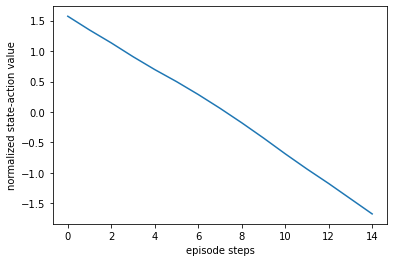

Episode 4, f(w) = 4.19, w = [1.9]
t=0 i=0 action=1
wt_prev=[1.9]
wt_next=[1.8]
f(wt)=4.36
rs=[4.36]
xt_prev=[ 0.    0.    0.19 -1.8  -1.8  -2.  ]
xt_next=[ 0.17  0.17  0.17 -1.8  -1.8  -1.8 ]
f_hist=[4.36, 4.19, 4.19]
g_hist=[array([-1.6]), array([-1.8]), array([-1.8])]
w_hist=[array([1.8]), array([1.9]), array([1.9])]
t=1 i=0 action=1
wt_prev=[1.8]
wt_next=[1.7]
f(wt)=4.510000000000001
rs=[4.51]
xt_prev=[ 0.17  0.17  0.17 -1.8  -1.8  -1.8 ]
xt_next=[ 0.15  0.32  0.32 -1.6  -1.8  -1.8 ]
f_hist=[4.510000000000001, 4.36, 4.19]
g_hist=[array([-1.4]), array([-1.6]), array([-1.8])]
w_hist=[array([1.7]), array([1.8]), array([1.9])]
t=2 i=0 action=2
wt_prev=[1.7]
wt_next=[1.8]
f(wt)=4.36
rs=[4.36]
xt_prev=[ 0.15  0.32  0.32 -1.6  -1.8  -1.8 ]
xt_next=[-0.15  0.    0.17 -1.4  -1.6  -1.8 ]
f_hist=[4.36, 4.510000000000001, 4.36]
g_hist=[array([-1.6]), array([-1.4]), array([-1.6])]
w_hist=[array([1.8]), array([1.7]), array([1.8])]
t=3 i=0 action=2
wt_prev=[1.8]
wt_next=[1.9]
f(wt)=4.19
rs=[4.19]


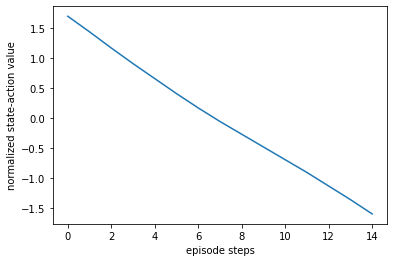

Episode 5, f(w) = 4.19, w = [1.9]
t=0 i=0 action=2
wt_prev=[1.9]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.19  0.4   0.4  -2.   -2.2  -2.2 ]
xt_next=[-0.19  0.    0.21 -1.8  -2.   -2.2 ]
f_hist=[4.0, 4.19, 4.0]
g_hist=[array([-2.]), array([-1.8]), array([-2.])]
w_hist=[array([2.]), array([1.9]), array([2.])]
t=1 i=0 action=1
wt_prev=[2.]
wt_next=[1.9]
f(wt)=4.19
rs=[4.19]
xt_prev=[-0.19  0.    0.21 -1.8  -2.   -2.2 ]
xt_next=[ 0.19  0.    0.19 -2.   -1.8  -2.  ]
f_hist=[4.19, 4.0, 4.19]
g_hist=[array([-1.8]), array([-2.]), array([-1.8])]
w_hist=[array([1.9]), array([2.]), array([1.9])]
t=2 i=0 action=1
wt_prev=[1.9]
wt_next=[1.8]
f(wt)=4.36
rs=[4.36]
xt_prev=[ 0.19  0.    0.19 -2.   -1.8  -2.  ]
xt_next=[ 0.17  0.36  0.17 -1.8  -2.   -1.8 ]
f_hist=[4.36, 4.19, 4.0]
g_hist=[array([-1.6]), array([-1.8]), array([-2.])]
w_hist=[array([1.8]), array([1.9]), array([2.])]
t=3 i=0 action=1
wt_prev=[1.8]
wt_next=[1.7]
f(wt)=4.510000000000001
rs=[4.51]
xt_prev=[ 0.17  0.36  0.17 -1.8  -2.   -1.8

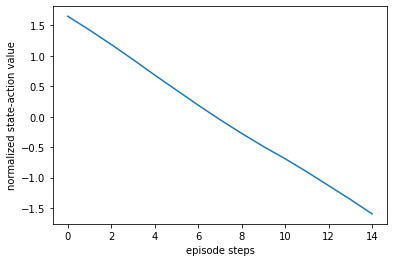

Episode 6, f(w) = 4.00, w = [2.]
t=0 i=0 action=1
wt_prev=[2.]
wt_next=[1.9]
f(wt)=4.19
rs=[4.19]
xt_prev=[-0.19  0.    0.   -1.8  -2.   -2.  ]
xt_next=[ 0.19  0.    0.19 -2.   -1.8  -2.  ]
f_hist=[4.19, 4.0, 4.19]
g_hist=[array([-1.8]), array([-2.]), array([-1.8])]
w_hist=[array([1.9]), array([2.]), array([1.9])]
t=1 i=0 action=2
wt_prev=[1.9]
wt_next=[2.]
f(wt)=4.0
rs=[4.]
xt_prev=[ 0.19  0.    0.19 -2.   -1.8  -2.  ]
xt_next=[-0.19  0.   -0.19 -1.8  -2.   -1.8 ]
f_hist=[4.0, 4.19, 4.0]
g_hist=[array([-2.]), array([-1.8]), array([-2.])]
w_hist=[array([2.]), array([1.9]), array([2.])]
t=2 i=0 action=2
wt_prev=[2.]
wt_next=[2.1]
f(wt)=3.79
rs=[3.79]
xt_prev=[-0.19  0.   -0.19 -1.8  -2.   -1.8 ]
xt_next=[-0.21 -0.4  -0.21 -2.   -1.8  -2.  ]
f_hist=[3.79, 4.0, 4.19]
g_hist=[array([-2.2]), array([-2.]), array([-1.8])]
w_hist=[array([2.1]), array([2.]), array([1.9])]
t=3 i=0 action=2
wt_prev=[2.1]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.21 -0.4  -0.21 -2.   -1.8  -2.  

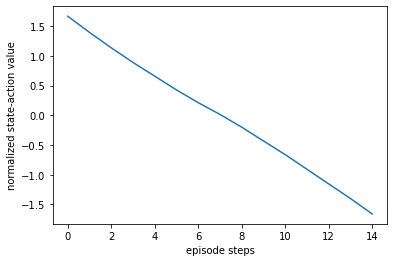

Episode 7, f(w) = 3.79, w = [2.1]
t=0 i=0 action=2
wt_prev=[2.1]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.21  0.    0.   -2.   -2.2  -2.2 ]
xt_next=[-0.23 -0.44 -0.23 -2.2  -2.   -2.2 ]
f_hist=[3.5599999999999996, 3.79, 4.0]
g_hist=[array([-2.4]), array([-2.2]), array([-2.])]
w_hist=[array([2.2]), array([2.1]), array([2.])]
t=1 i=0 action=2
wt_prev=[2.2]
wt_next=[2.3]
f(wt)=3.3099999999999996
rs=[3.31]
xt_prev=[-0.23 -0.44 -0.23 -2.2  -2.   -2.2 ]
xt_next=[-0.25 -0.48 -0.69 -2.4  -2.2  -2.  ]
f_hist=[3.3099999999999996, 3.5599999999999996, 3.79]
g_hist=[array([-2.6]), array([-2.4]), array([-2.2])]
w_hist=[array([2.3]), array([2.2]), array([2.1])]
t=2 i=0 action=1
wt_prev=[2.3]
wt_next=[2.2]
f(wt)=3.5599999999999996
rs=[3.56]
xt_prev=[-0.25 -0.48 -0.69 -2.4  -2.2  -2.  ]
xt_next=[ 0.25  0.   -0.23 -2.6  -2.4  -2.2 ]
f_hist=[3.5599999999999996, 3.3099999999999996, 3.5599999999999996]
g_hist=[array([-2.4]), array([-2.6]), array([-2.4])]
w_hist=[array([2.2]), array([2.3

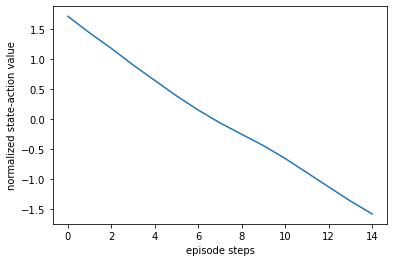

Episode 8, f(w) = 2.75, w = [2.5]
t=0 i=0 action=1
wt_prev=[2.5]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[ 0.   -0.29 -0.29 -3.   -2.8  -2.8 ]
xt_next=[ 0.29  0.29  0.   -3.   -3.   -2.8 ]
f_hist=[3.039999999999999, 2.7499999999999987, 2.7499999999999987]
g_hist=[array([-2.8]), array([-3.]), array([-3.])]
w_hist=[array([2.4]), array([2.5]), array([2.5])]
t=1 i=0 action=2
wt_prev=[2.4]
wt_next=[2.5]
f(wt)=2.7499999999999987
rs=[2.75]
xt_prev=[ 0.29  0.29  0.   -3.   -3.   -2.8 ]
xt_next=[-0.29  0.    0.   -2.8  -3.   -3.  ]
f_hist=[2.7499999999999987, 3.039999999999999, 2.7499999999999987]
g_hist=[array([-3.]), array([-2.8]), array([-3.])]
w_hist=[array([2.5]), array([2.4]), array([2.5])]
t=2 i=0 action=1
wt_prev=[2.5]
wt_next=[2.4]
f(wt)=3.039999999999999
rs=[3.04]
xt_prev=[-0.29  0.    0.   -2.8  -3.   -3.  ]
xt_next=[ 0.29  0.    0.29 -3.   -2.8  -3.  ]
f_hist=[3.039999999999999, 2.7499999999999987, 3.039999999999999]
g_hist=[array([-2.8]), array([-3.]), array([-2.8])

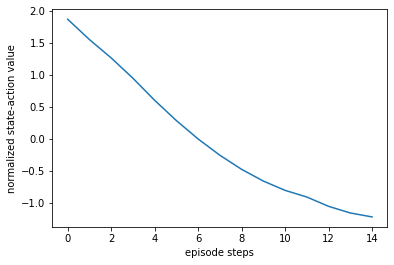

Episode 9, f(w) = 0.16, w = [3.2]
t=0 i=0 action=1
wt_prev=[3.2]
wt_next=[3.1]
f(wt)=0.5899999999999963
rs=[0.59]
xt_prev=[-0.43 -0.84 -1.23 -4.2  -4.   -3.8 ]
xt_next=[ 0.43  0.   -0.41 -4.4  -4.2  -4.  ]
f_hist=[0.5899999999999963, 0.1599999999999957, 0.5899999999999963]
g_hist=[array([-4.2]), array([-4.4]), array([-4.2])]
w_hist=[array([3.1]), array([3.2]), array([3.1])]
t=1 i=0 action=2
wt_prev=[3.1]
wt_next=[3.2]
f(wt)=0.1599999999999957
rs=[0.16]
xt_prev=[ 0.43  0.   -0.41 -4.4  -4.2  -4.  ]
xt_next=[-0.43  0.   -0.43 -4.2  -4.4  -4.2 ]
f_hist=[0.1599999999999957, 0.5899999999999963, 0.1599999999999957]
g_hist=[array([-4.4]), array([-4.2]), array([-4.4])]
w_hist=[array([3.2]), array([3.1]), array([3.2])]
t=2 i=0 action=2
wt_prev=[3.2]
wt_next=[3.3]
f(wt)=-0.29000000000000536
rs=[-0.29]
xt_prev=[-0.43  0.   -0.43 -4.2  -4.4  -4.2 ]
xt_next=[-0.45 -0.88 -0.45 -4.4  -4.2  -4.4 ]
f_hist=[-0.29000000000000536, 0.1599999999999957, 0.5899999999999963]
g_hist=[array([-4.6]), array([-4.4]

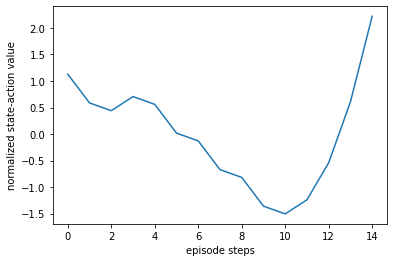

Episode 10, f(w) = -2.29, w = [3.7]


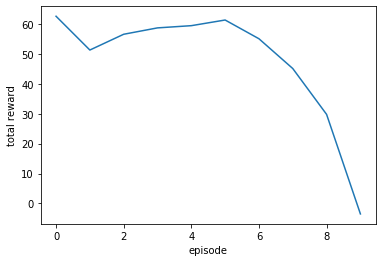

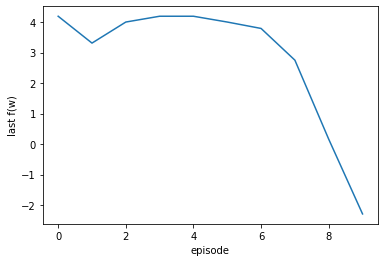

-4.0169999999999835

In [2]:
def f2d(w):
  x = w[0]
  y = w[1]
  return -(x-1)**2 - (y-1.5)**2
f2d_w0 = [2,1]

def f1d(w):
  return -(w[0]-1)**2 + 5

# Gradient at 1d.
# We won't have this information for complex f, but want to replicate Ke li 2017 closely.
def g1d(w):
  return np.array([-2 * (w[0]-1)])
  
f1d_w0 = [2.0]

last_fs = []
for i in range(10):
  last_f = optimize_with_rl(f1d, g1d, f1d_w0)
  last_fs.append(last_f)
  
np.mean(last_fs)

In [3]:
last_fs

[4.99,
 -5.240000000000007,
 3.5599999999999996,
 5.0,
 0.1599999999999957,
 -30.999999999999893,
 4.99,
 4.91,
 -25.249999999999922,
 -2.290000000000008]